#DATASCI W261: Machine Learning at Scale 

**Full Submission from Both Groups    
W261-1 Fall 2015   
Week 14: Final Homework  
December 16, 2015**  

**Main Contributors: Michael Demertzi, Doug Kelley, Arthur Mak, Marguerite Oneto, James Route, Kasane Utsumi, Sayantan Satpati, Anant Srivastava, Rajesh Thallam**

#HW14.1
>Please resubmit HW13 (HW13.1 - HW13.5). Dont forget to explore different numbers of hash buckets! What is a good number of hash buckets

Please see HW13.1 to HW13.5 below. Key changes: 
- HW 13.1-HW13.3 (used single RDD solution with "Joins")
- HW 13.4-HW13.5 (major clean up of code and heatmap result outputs)

Good number of hash buckets is 50,000 (given we studied 48 hyperparemter combinations with the choice of 10k, 100k, 500k, and 100k buckets).

# HW 13.1: Spark Implementation of Basic PageRank
>Write a basic Spark implementation of the iterative PageRank algorithm that takes sparse adjacency lists as input.  Make sure that your implementation utilizes teleportation (1-damping/the number of nodes in the network), and further, distributes the mass of dangling nodes with each iteration so that the output of each iteration is correctly normalized (sums to 1).

>[NOTE: The PageRank algorithm assumes that a random surfer (walker), starting from a random web page, chooses the next page to which it will move by clicking at random, with probability d, one of the hyperlinks in the current page. This probability is represented by a so-called ‘damping factor’ d, where d ∈ (0, 1). Otherwise, with probability (1 − d), the surfer jumps to any web page in the network. If a page is a dangling end, meaning it has no outgoing hyperlinks, the random surfer selects an arbitrary web page from a uniform distribution and “teleports” to that page.]

>In your Spark solution, please use broadcast variables and caching to make sure your code is as efficient as possible.

>As you build your code, use the following test data to check your implementation:

>s3://ucb-mids-mls-networks/PageRank-test.txt

>Set the teleportation parameter to 0.15 (1-d, where d, the damping factor is set to 0.85), and crosscheck your work with the true result, displayed in the first image in the Wikipedia article:

>https://en.wikipedia.org/wiki/PageRank

>and here for reference are the corresponding resulting PageRank probabilities:

>A,0.033    
B,0.384  
C,0.343  
D,0.039  
E,0.081  
F,0.039  
G,0.016  
H,0.016  
I,0.016  
J,0.016  
K,0.016

>Run this experiment locally first. Report the local configuration that you used and how long in minutes and seconds it takes to complete your job.

>Repeat this experiment on AWS. Report the AWS cluster configuration that you used and how long in minutes and seconds it takes to complete your job. (in your notebook, cat the cluster config file)

##13.1.1 Start Spark

In [6]:
#set SPARK_HOME to be the Spark directory being used in your local computer
# SPARK_HOME="/Users/ssatpati/0-DATASCIENCE/TOOLS/spark-1.5.1-bin-hadoop2.6"
SPARK_HOME="/Users/maktrix/Dropbox/Berkeley/W261_ML_scale/spark-1.5.1-bin-hadoop2.6"
# SPARK_HOME='/usr/local/Cellar/apache-spark/1.5.0/libexec/'

import os
import sys
#Escape L for line numbers
spark_home = os.environ['SPARK_HOME'] = SPARK_HOME
if not spark_home:
    raise ValueError('SPARK_HOME enviroment variable is not set')
sys.path.insert(0,os.path.join(spark_home,'python'))
sys.path.insert(0,os.path.join(spark_home,'python/lib/py4j-0.8.2.1-src.zip'))
execfile(os.path.join(spark_home,'python/pyspark/shell.py'))

Welcome to
      ____              __
     / __/__  ___ _____/ /__
    _\ \/ _ \/ _ `/ __/  '_/
   /__ / .__/\_,_/_/ /_/\_\   version 1.5.1
      /_/

Using Python version 2.7.10 (default, Oct 19 2015 18:31:17)
SparkContext available as sc, HiveContext available as sqlContext.


##13.1.2 Get Data

In [2]:
#save test data to local
!aws s3 cp s3://ucb-mids-mls-networks/PageRank-test.txt PageRank-test.txt
    
#check data file
!cat PageRank-test.txt

download: s3://ucb-mids-mls-networks/PageRank-test.txt to ./PageRank-test.txt
B	{'C': 1}
C	{'B': 1}
D	{'A': 1, 'B': 1}
E	{'D': 1, 'B': 1, 'F': 1}
F	{'B': 1, 'E': 1}
G	{'B': 1, 'E': 1}
H	{'B': 1, 'E': 1}
I	{'B': 1, 'E': 1}
J	{'E': 1}
K	{'E': 1}


## 13.1.3  Define PageRank Functions
This is the new PageRank function that used "join":

In [161]:
%%writefile spark_13_2_v2.py
import ast
import pprint
import sys
from math import log, exp, log1p
from pyspark import SparkContext
from pyspark import SparkConf

#global Var
g_dangling_mass = None

def u(s):
    return s.decode('utf-8')

def parse_line(line):
    tokens = line.split('\t')
    key = tokens[0]
    adj_list = ast.literal_eval(tokens[1])
    return (u(key), [u(k) for k,v in adj_list.iteritems()])

def preproc(t):
    l = [t]
    for x in t[1]:
        l.append((u(x),[]))
    return l

def contributions(t):
    #global g_dangling_mass
    l = [(t[0], 0)]
    w = t[1][1]
    adj_list = t[1][0]
    key = None
    if len(adj_list) == 0:
        #g_dangling_mass += w
        l.append(('DANGLING', w))
    else:
        for n in adj_list:
            l.append((n, w/len(adj_list)))
    return l

def page_rank(w, n, dangling_mass, LH, RH):
    # w = (tp / n) + (1 - tp) * ((dangling_mass/n) + w)
    # OR
    # w = (tp / n) + ((1 - tp)/n) * (dangling_mass + wn)
    # OR
    # w = LH + RH * (dangling_mass + wn)
    # OR
    # w = LH + exp(log(RH) + log(dangling_mass + wn))
    
    w = LH + exp(log(RH) + log(dangling_mass + w * n))
    return w

if __name__ == '__main__':
    print 'Number of arguments:', len(sys.argv), 'arguments.'
    print 'Argument List:', str(sys.argv)
    
    if len(sys.argv) != 5:
        print 'Incorrect number of arguments passed, Aborting...'
        sys.exit(1)
        
    # Init Spark Context
    #conf = SparkConf()
    sc = SparkContext(appName="Page Rank")
    
    lines = sc.textFile(sys.argv[1]).map(parse_line)
    #print '\n### Original Dataset:'
    #pprint.pprint(lines.sortByKey().collect())

    # Cache the linkys (They are Bigger)
    num_partitions = int(sys.argv[4])
    links = lines.flatMap(preproc) \
                 .reduceByKey(lambda x, y: x + y) \
                 .partitionBy(num_partitions) \
                 .cache()
    #print '\n### Pre-Processed Dataset (Links):'
    #pprint.pprint(links.collect())

    # Use map values to partition ranks in the same way as links
    n = links.count()
    ranks = links.mapValues(lambda x: float(1)/n)
    #print '\n### Inital Ranks:'
    #pprint.pprint(ranks.collect())

    #sum_partial_diff_PR = float('inf')
    #Teleportation & Damping Factor (Calculate & Pass)
    tp=0.15
    LH = tp / n
    RH = (1 - tp) / n
    sys.stderr.write('### Teleportation: {0}, LH: {1}, RH: {2}'.format(tp, LH, RH))
    cnt = 1

    #while sum_partial_diff_PR > .005:
    while cnt <= int(sys.argv[3]):
        #global g_dangling_mass
        #g_dangling_mass = sc.accumulator(0.0)
        contribs = links.join(ranks) \
                    .flatMap(contributions) \
                    .reduceByKey(lambda x, y: x + y)
        dangling_mass = contribs.lookup('DANGLING')[0]
        ranks = contribs.filter(lambda x: x[0] != 'DANGLING') \
                        .mapValues(lambda x: page_rank(x, n, dangling_mass, LH, RH))
        sys.stderr.write('\n[{0}] Dangling Mass: {1}'.format(cnt, dangling_mass))
    
        cnt += 1

    sc.parallelize(ranks.takeOrdered(100, key=lambda x: -x[1])).saveAsTextFile(sys.argv[2])
    
    sc.stop()


Writing spark_13_2_v2.py


##13.1.4 Run PageRank in Spark locally
Submit Spark job of PageRank algorithm with 30 iterations using a local machine with 2 cores.

In [7]:
out_dir = "local_output"
!rm -rf $out_dir
!time $SPARK_HOME/bin/spark-submit --name "Page Rank" --master local[2] ./spark_13_2_v2.py \
                PageRank-test.txt $out_dir 30 2
!cat $out_dir/part-000*

Number of arguments: 5 arguments.
Argument List: ['/Users/maktrix/Dropbox/Berkeley/W261_ML_scale/w261_hw14/arthur/./spark_13_2_v2.py', 'PageRank-test.txt', 'local_output', '30', '2']
15/12/16 17:02:37 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
15/12/16 17:02:39 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
15/12/16 17:02:39 WARN MetricsSystem: Using default name DAGScheduler for source because spark.app.id is not set.
### Teleportation: 0.15, LH: 0.0136363636364, RH: 0.0772727272727
[1] Dangling Mass: 0.0909090909091
[2] Dangling Mass: 0.0592975206612
[3] Dangling Mass: 0.0379464062109
[4] Dangling Mass: 0.0640190695934
[5] Dangling Mass: 0.0375959647951
[6] Dangling Mass: 0.0386749363905
[7] Dangling Mass: 0.0341177257382
[8] Dangling Mass: 0.0346526855821
[9] Dangling Mass: 0.0332641479909
[10] Dangling Mass: 0.0332687068063
[11] Dangling Mass: 0.0329301017862
[12] Dan

## 13.1.5 Run PageRank in Spark on EMR cluster

Create simple configuration to optimize cluster run-speed:

In [10]:
%%writefile emr_config_spark_max.json
[
  {
    "Classification": "spark",
    "Properties": {
      "maximizeResourceAllocation": "true"
    }
  }
]

Overwriting emr_config_spark_max.json


In [8]:
#create cluster
!aws emr create-cluster --name "13_1" --ami-version 3.8 --applications Name=Spark --ec2-attributes KeyName=w261_key2 --log-uri s3://ucb-mids-mls-arthur-mak/test_spark/logs --instance-type m3.xlarge  --instance-count 3 --use-default-roles 

j-2FPN8DOCU3MSA


In [20]:
#Look up the IP from EMR console & ssh into the cluster by giving local permission
#>>> ssh -i <key_name> hadoop@ec2-52-34-202-120.us-west-2.compute.amazonaws.com

#At the local termainal, copy main PySpark file into EMR master node
PEM_HOME="/Users/maktrix/Dropbox/Berkeley/W261_ML_scale"
!scp -i $PEM_HOME/w261_key2.pem spark_13_2_v2.py hadoop@ec2-52-34-202-120.us-west-2.compute.amazonaws.com:.

#Remove output folder of same name
out_dir="13_1_output"
!aws s3 rm --recursive s3://hw14/$out_dir

spark_13_2_v2.py                              100% 3118     3.0KB/s   00:00    


At the EMR master terminal, use the following command to run the Spark job:
- time /home/hadoop/spark/bin/spark-submit --master yarn-cluster /home/hadoop/spark_13_2_v2.py s3n://ucb-mids-mls-networks/PageRank-test.txt s3n://hw14/13_1_output 30 3

Time required to run job:  
real	0m35.039s  
user	0m7.108s  
sys  	0m1.132s  

In [22]:
#copy result to local and see result
!rm -r $out_dir
!aws s3 cp --recursive s3://hw14/$out_dir $out_dir
!cat $out_dir/*

rm: 13_1_output: No such file or directory
download: s3://hw14/13_1_output/_SUCCESS to 13_1_output/_SUCCESS
download: s3://hw14/13_1_output/part-00001 to 13_1_output/part-00001
download: s3://hw14/13_1_output/part-00000 to 13_1_output/part-00000
(u'B', 0.38359681276779006)
(u'C', 0.34371441659524948)
(u'E', 0.080885694740792297)
(u'D', 0.039087093081437922)
(u'F', 0.039087093081437922)
(u'A', 0.032781494002797999)
(u'H', 0.016169479146098883)
(u'J', 0.016169479146098883)
(u'G', 0.016169479146098883)
(u'K', 0.016169479146098883)
(u'I', 0.016169479146098883)


## 13.1.6 Compare execution time
The local configuration is as follow:
- MacBook Air (13-inch, Mid 2013)
- Processor 1.4 GHz Intel Core i5
- 2 cores
- Memory 8 GB 1600 MHz DDR3
- Graphics Intel HD Graphics 5000 1536 MB
- OSX version 10.10.2

The EMR cluster configuration is as follow:
- instance-type m3.xlarge  
- instance-count 3
- region us-west-2

We used the elapsed real time between command line invocation and termination as our time benchmark for execution time:
- Total execution time for local computer is: 25.246s
- Total execution time for EMR cluster is: 35.039s

The real execution time for EMR cluster is actually longer even though computational time is likely to be less for the EMR cluster. 

# HW 13.2: Applying PageRank to the Wikipedia hyperlinks network===
>Run your Spark PageRank implementation on the Wikipedia dataset for 10 iterations,
and display the top 100 ranked nodes (with alpha = 0.85).

>Run your PageRank implementation on the Wikipedia dataset for 50 iterations,
and display the top 100 ranked nodes (with teleportation factor of 0.15). 
Plot the pagerank values for the top 100 pages resulting from the 50 iterations run. Then plot the pagerank values for the same 100 pages that resulted from the 10 iterations run.  Comment on your findings.  Have the top 100 ranked pages changed? Have the pagerank values changed? Explain.

>Report the AWS cluster configuration that you used and how long in minutes and seconds it takes to complete your job.

>NOTE: Wikipedia data is located on S3 at  s3://ucb-mids-mls-networks/wikipedia/
- s3://ucb-mids-mls-networks/wikipedia/all-pages-indexed-out.txt #Graph
- s3://ucb-mids-mls-networks/wikipedia/indices.txt               #Page titles and page Ids

##13.2.1 Running on AWS

#### Commands

```
/usr/bin/spark-submit --master yarn-cluster /home/hadoop/spark_13_3.py s3n://ucb-mids-mls-networks/wikipedia/all-pages-indexed-out.txt s3n://ucb-mids-mls-sayantan-satpati/spark/hw13_2_3 10 40


/usr/bin/spark-submit --master yarn-cluster /home/hadoop/spark_13_3.py s3n://ucb-mids-mls-networks/wikipedia/all-pages-indexed-out.txt s3n://ucb-mids-mls-sayantan-satpati/spark/hw13_2_4 50 40

```

***Cluster Size: 10 m3.xlarge***

***10 Iterations. Time Taken: 48mins, 37sec***

***50 Iterations. Time Taken: 3hrs, 33mins, 59sec  ***

***Each iteration took 4 mins 10 secs approx***

##13.2.2 Download Output form S3 Buckets for both runs (10 & 50 iterations)


In [24]:
out_dir_10 = "output_13_2_1"
!rm -rf $out_dir_10;mkdir $out_dir_10;
!aws s3 cp --recursive s3://ucb-mids-mls-sayantan-satpati/spark/hw13_2_3/ $out_dir_10
    
out_dir_50 = "output_13_2_2"
!rm -rf $out_dir_50;mkdir $out_dir_50;
!aws s3 cp --recursive s3://ucb-mids-mls-sayantan-satpati/spark/hw13_2_4/ $out_dir_50

download: s3://ucb-mids-mls-sayantan-satpati/spark/hw13_2_3/part-00006 to output_13_2_1/part-00006
download: s3://ucb-mids-mls-sayantan-satpati/spark/hw13_2_3/part-00005 to output_13_2_1/part-00005
download: s3://ucb-mids-mls-sayantan-satpati/spark/hw13_2_3/part-00002 to output_13_2_1/part-00002
download: s3://ucb-mids-mls-sayantan-satpati/spark/hw13_2_3/part-00004 to output_13_2_1/part-00004
download: s3://ucb-mids-mls-sayantan-satpati/spark/hw13_2_3/part-00003 to output_13_2_1/part-00003
download: s3://ucb-mids-mls-sayantan-satpati/spark/hw13_2_3/part-00007 to output_13_2_1/part-00007
download: s3://ucb-mids-mls-sayantan-satpati/spark/hw13_2_3/part-00000 to output_13_2_1/part-00000
download: s3://ucb-mids-mls-sayantan-satpati/spark/hw13_2_3/part-00008 to output_13_2_1/part-00008
download: s3://ucb-mids-mls-sayantan-satpati/spark/hw13_2_3/_SUCCESS to output_13_2_1/_SUCCESS
download: s3://ucb-mids-mls-sayantan-satpati/spark/hw13_2_3/part-00001 to output_13_2_1/part-00001
download: s3:/

##13.2.3 Analyzing both runs (10 & 50 iterations)


In [26]:
# Load Indices
!aws s3 cp s3://ucb-mids-mls-networks/wikipedia/indices.txt indices.txt
index = {}
with open('indices.txt') as f:
    for l in f:
        t  = l.strip().split('\t')
        index[t[1].strip()] = t[0].strip()

download: s3://ucb-mids-mls-networks/wikipedia/indices.txt to ./indices.txt


In [27]:
# Load Page Ranks
import ast
import glob
import pprint

pr1 = []
pr2 = []

for f_name in glob.glob(out_dir_10 + '/part-*'):
    with open(f_name) as f:
        for l in f:
            t = ast.literal_eval(l)
            pr1.append((t[1], t[0]))
pr1 = sorted(pr1, key=lambda x: -x[0])
print '\n # Page Ranks: 10 iterations'
pprint.pprint(pr1[:5])

for f_name in glob.glob(out_dir_50 + '/part-*'):
    with open(f_name) as f:
        for l in f:
            t = ast.literal_eval(l)
            pr2.append((t[1], t[0]))
pr2 = sorted(pr2, key=lambda x: -x[0])
print '\n # Page Ranks: 50 iterations'
pprint.pprint(pr2[:5])


 # Page Ranks: 10 iterations
[(0.001461449194428846, u'13455888'),
 (0.0006663317376704976, u'1184351'),
 (0.000639805187632745, u'4695850'),
 (0.0005748538827022329, u'5051368'),
 (0.0004503047143403479, u'1384888')]

 # Page Ranks: 50 iterations
[(0.0014615599818947208, u'13455888'),
 (0.0006660177937208579, u'1184351'),
 (0.0006396773758303842, u'4695850'),
 (0.0005747671983903149, u'5051368'),
 (0.00045012322227648923, u'1384888')]


##13.2.4 Comparison of Wikipedia Links (10 & 50 iterations)

* The top 100 from both the interations are same.
* In certain case, the ranks are slightly different (Rank 50 & 51: The links have been swapped between 2 runs)

In [29]:
from tabulate import tabulate
table = []
for i in xrange(100):
    table.append([i+1, pr1[i][0], 
                  pr2[i][0], 
                  index.get(pr1[i][1].replace("\"",""), 'NA'),
                  index.get(pr2[i][1].replace("\"",""), 'NA')])
print tabulate(table, headers=["#","Rank(10)","Rank(50)", "Link(10)", "Link(50)"])

  #     Rank(10)     Rank(50)  Link(10)                                  Link(50)
---  -----------  -----------  ----------------------------------------  ----------------------------------------
  1  0.00146145   0.00146156   United States                             United States
  2  0.000666332  0.000666018  Animal                                    Animal
  3  0.000639805  0.000639677  France                                    France
  4  0.000574854  0.000574767  Germany                                   Germany
  5  0.000450305  0.000450123  Arthropod                                 Arthropod
  6  0.000446601  0.00044667   Canada                                    Canada
  7  0.000444818  0.000444632  Insect                                    Insect
  8  0.000444204  0.000443879  List of sovereign states                  List of sovereign states
  9  0.000432995  0.000433142  United Kingdom                            United Kingdom
 10  0.000427885  0.000427708  India           

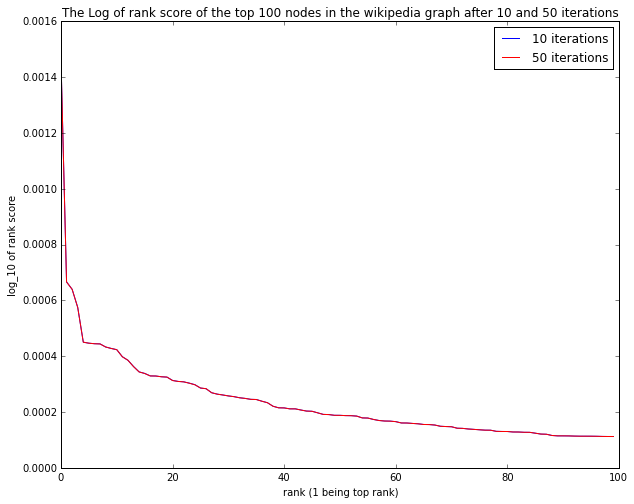

In [34]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

# plt.figure(figsize=(18,6))
# plt.subplot(121)
# plt.title("Top 100 Page Ranks - 10 Iterations")
# plt.ylabel('Page Rank')
# plt.plot([pr[0] for pr in pr1])

# plt.subplot(122)
# plt.title("Top 100 Page Ranks - 50 Iterations")
# plt.ylabel('Page Rank')
# plt.plot([pr[0] for pr in pr2])


#plot graph
ranks = list(range(1, 101, 1)) 
plt.figure(figsize=(10, 8))
plt.title('The Log of rank score of the top 100 nodes in the wikipedia graph after 10 and 50 iterations')
plt.ylabel('log_10 of rank score')
plt.xlabel('rank (1 being top rank)')
plt.xlim(0,100)
#legend tutorial: http://matplotlib.org/users/legend_guide.html#plotting-guide-legend
line_10,=plt.plot([pr[0] for pr in pr1], 'b')
line_50,=plt.plot([pr[0] for pr in pr2], 'r')
plt.legend([line_10, line_50], ['10 iterations', '50 iterations'])
plt.show() 

In the above plots, both lines coincide each other exactly. This means that the rank scores did not noticeably change from 10 iterations to 50 iterations. 

#HW 13.3: Spark GraphX versus your implementation of PageRank

>Run the Spark  GraphX PageRank implementation on the Wikipedia dataset for 10 iterations, and display the top 100 ranked nodes (with alpha = 0.85).

>Run your PageRank implementation on the Wikipedia dataset for 50 iterations, and display the top 100 ranked nodes (with teleportation factor of 0.15). Have the top 100 ranked pages changed? Comment on your findings. Plot both 100 curves.

>Report the AWS cluster configuration that you used and how long in minutes and seconds it takes to complete this job.

>Put the runtime results of HW13.2 and HW13.3 in a tabular format (with rows corresponding to implemention and columns corresponding to experiment setup (10 iterations, 50 iterations)). Discuss the run times and explaing the differences. 

>Plot the pagerank values for the top 100 pages resulting from the 50 iterations run (using GraphX). Then plot the pagerank values for the same 100 pages that resulted from the 50 iterations run of your homegrown pagerank implemnentation.  Comment on your findings.  Have the top 100 ranked pages changed? Have the pagerank values changed? Explain.

##13.3.1 Overview of setting up code to run Scala
Note: We ran everything on Scala. 

We use SBT for building and followed the folder structure:

./HW13_3
├── build.sbt
├── project
│   └── plugins.sbt
└── HW13_3.scala

(taken from) https://github.com/MIDS-scaling-up/coursework/tree/master/week9/hw



##13.3.2 Create build.sbt

In [ ]:
lazy val common = Seq(
  organization := "week9.mids",
  version := "0.1.0",
  scalaVersion := "2.10.4",
  libraryDependencies ++= Seq(
    "org.apache.spark" %% "spark-core" % "1.5.0",
    "org.apache.spark" %% "spark-graphx" % "1.5.0"
  ),
  mergeStrategy in assembly <<= (mergeStrategy in assembly) { (old) =>
     {
      case PathList("META-INF", xs @ _*) => MergeStrategy.discard
      case x => MergeStrategy.first
     }
  }
)

lazy val HW13_3 = (project in file(".")).
  settings(common: _*).
  settings(
    name := "HW13_3",
    mainClass in (Compile, run) := Some("HW13_3.Main"))                                                             

##13.3.3 Create plugins.sbt

In [ ]:
addSbtPlugin("com.typesafe.sbteclipse" % "sbteclipse-plugin" % "3.0.0")
addSbtPlugin("com.eed3si9n" % "sbt-assembly" % "0.13.0")

##13.3.4 Create main Scala Spark code (using GraphX and Mllib)

In [ ]:
import org.apache.spark.SparkContext
import org.apache.spark.SparkContext._
import org.apache.spark.SparkConf
import org.apache.spark._
// To make some of the examples work we will also need RDD
import org.apache.spark.rdd.RDD
import org.apache.spark._
import org.apache.spark.graphx._
import scala.util.hashing._
import java.io._

/*
Takes four arguments:
    1. output path
    2. num iterations
    3. Teleportation Factor
    4. take first x element
    5. Input file path

*/
object Main extends App {


  	val conf = new SparkConf().setAppName("HW13_3")
	val sc = new SparkContext(conf)
    
    //set up s3
	sc.hadoopConfiguration.set("fs.s3n.awsAccessKeyId", apikey)
	sc.hadoopConfiguration.set("fs.s3n.awsSecretAccessKey", apisecret)

    //load data
	val lines = sc.textFile(args(4))

    //this function process input and creates Edge 
    def getEdge(s:String):Array[Edge[Double]] = {

          val thisData = s.split("\\t+")

          val src = thisData(0)

          //get neighbors via text manipulation
          val neighbors  = thisData(1).trim.stripPrefix("{").stripSuffix("}").trim.split(",")
          var finalArr:Array[Edge[Double]] = new Array[Edge[Double]](neighbors.length)

          for((x,i) <- neighbors.zipWithIndex) finalArr(i) = Edge(src.toLong,x.trim.split(":")(0).trim.stripSuffix("'").stripPrefix("'").toLong,1.0)


      return finalArr
    }
	
    //this function takes input and creates vertex
	def getVertex(s:String):Array[(VertexId,(String))] = {
               
               val thisData = s.split("\\t+")
                
                val neighbors  = thisData(1).trim.stripPrefix("{").stripSuffix("}").trim.split(",")
                var finalArr:Array[(VertexId,(String))] = new Array[(VertexId,(String))](neighbors.length+1)
		
                finalArr(0) = (thisData(0).toLong,("Something"))
                for((x,i) <- neighbors.zipWithIndex) finalArr(i+1) = (x.trim.split(":")(0).trim.stripSuffix("'").stripPrefix("'").toLong, ("Something"))
                
                return finalArr
        
    }
    
    //create GraphX Graph object
	var reddits: RDD[ (VertexId, (String)) ] = lines.flatMap(getVertex).distinct()
	val comments: RDD[Edge[Double]] = lines.flatMap(getEdge)
	val graph = Graph(reddits, comments)
    
    //run pagerank
	val ranks = graph.staticPageRank(args(1).toInt,args(2).toFloat).vertices
    
    //take first x element in descending order
	val finalStr = ranks.takeOrdered(args(3).toInt)(Ordering[BigDecimal].reverse.on(x=>x._2)).mkString("\n") //.saveAsTextFile("s3://ucb-mids-mls-kasaneutsumi/test133/")

    //write final output to local file (ok to write to local since only 100 lines)
    val wfile = new File(args(0));
    val pw = new PrintWriter(wfile)
    pw.write(finalStr)
    pw.close
}

##13.3.5 Create cluster and install needed components

In [ ]:
#Create Spark job
!aws emr create-cluster --name "testK3" --release-label emr-4.2.0 --applications Name=Spark \
    --instance-count 6 --use-default-roles --ec2-attributes KeyName=w261-kasane --instance-type m3.xlarge 
    --enable-debugging --log-uri s3://ucb-mids-mls-group-e/hw13 
    --configurations file://./emr_config_spark_max.json 
    --bootstrap-action Path="s3://ucb-mids-mls-kasaneutsumi/setup.sh"

#### Note: 
--Bootstrap-action is for bootstrapping sbt install. Code is below. 

>curl https://bintray.com/sbt/rpm/rpm | sudo tee /etc/yum.repos.d/bintray-sbt-rpm.repo
sudo yum install -y java-1.8.0-openjdk-headless sbt

--configurations is for uploading configuraiton to speed up spark job. Code is below

>[
 {
   "Classification": "spark",
   "Properties": {
     "maximizeResourceAllocation": "true"
   }
 }
]

##13.3.6 Run the Spark GraphX PageRank (10 iterations, alpha=0.85, display 100 top ranked nodes)

In [ ]:
!time /usr/lib/spark/bin/spark-submit $(find target -iname "*assembly*.jar") \
    result13_3_1 10 0.85 100 s3://ucb-mids-mls-networks/wikipedia/all-pages-indexed-out.txt

In [ ]:
#### Result (snippet)
(13455888,3003.974079357295)
(1184351,2092.3433407263656)
(1384888,1619.6075071779119)
(6113490,1565.424633275681)
(4695850,1478.132013208902)
(5051368,1320.9505300242079)
(7576704,1117.5573599923648)
(6076759,1098.0625995150724)
(9276255,1021.1842269714457)
(7835160,1007.4929532446756)
(4196067,988.7675474399468)
(2437837,963.7018936198781)
(15164193,955.5641628116225)
..and so on

##13.3.7 Run the Spark GraphX PageRank (50 iterations, alpha=0.85, display 100 top ranked nodes)

In [ ]:
!time /usr/lib/spark/bin/spark-submit $(find target -iname "*assembly*.jar") \
    result13_3_2 50 0.15 100 s3://ucb-mids-mls-networks/wikipedia/all-pages-indexed-out.txt

In [ ]:
#### Result (snippet)
(13455888,6247.50616433003)
(1184351,2846.924076772375)
(4695850,2734.3307175916707)
(5051368,2456.869142308948)
(1384888,1924.0726791155575)
(2437837,1909.3119247721568)
(6113490,1900.6012367972091)
(7902219,1897.380159902679)
(13425865,1851.4864095316357)
(6076759,1828.2567640691966)
(4196067,1809.9148026148632)
(6172466,1700.5259367791625)
..and so on

##13.3.8 Matching Index with Label
We now need to check whether the top 100 ranked page change. In order to do so, we need to match the index with the actual word label.

In [39]:
%%writefile MatchNameWithIndex.py
import sys
import ast
import json
from pyspark import SparkContext

def matchIndex(pagerank_file, indices_file, output_file):
    
    #page rank result
    result = sc.textFile(pagerank_file)
    result = result.map(lambda x: (ast.literal_eval(x)[0],ast.literal_eval(x)[1])) #.keyBy(lambda r: r[0])

    #indices file
    result2 = sc.textFile(indices_file) \
        .map(lambda x: (int(x.split("\t")[1]),x.split("\t")[0])) \
        
    #larger version "s3n://ucb-mids-mls-networks/wikipedia/indices.txt"
    #smaller version of index file->  sampleWikiIndex

    #join and sort
    joinedResult = result.join(result2).map(lambda (x,y): (y[1],y[0])).sortBy(lambda (k,v): -v) \
        .collect() #.saveAsTextFile(output_file)
    
    #write result
    with open(output_file,"w") as f:
        for line in joinedResult:
            f.write(str(line[0]) + "\t" + str(line[1]) + "\n")

if __name__ == "__main__":
    
    # two arguments
    #  1. page rank result in tuple format
    #  2. index file path
    
    if len(sys.argv) < 3:
        print >> sys.stderr, "Usage: nodename_score <pagerank_file> <indices_file> <output_file>"
        exit(-1)

    [pagerank_file, indices_file, output_file] = sys.argv[1:4]
    
    sc = SparkContext(appName="MatchNameWithIndex")
    matchIndex(pagerank_file , indices_file, output_file)    
    sc.stop()

Writing MatchNameWithIndex.py


In [ ]:
# run above for 10 iteration result
!time $SPARK_HOME/bin/spark-submit MatchNameWithIndex.py s3n://ucb-mids-mls-kasaneutsumi/result13_3_1 \
    s3n://ucb-mids-mls-networks/wikipedia/indices.txt result10Itr

In [ ]:
# run above for 50 iteration result
!time $SPARK_HOME/bin/spark-submit MatchNameWithIndex.py s3n://ucb-mids-mls-kasaneutsumi/result13_3_2 \
    s3n://ucb-mids-mls-networks/wikipedia/indices.txt result50Itr

##13.3.9 Creating table of top 100 ranks between 10 and 50-iteration cases

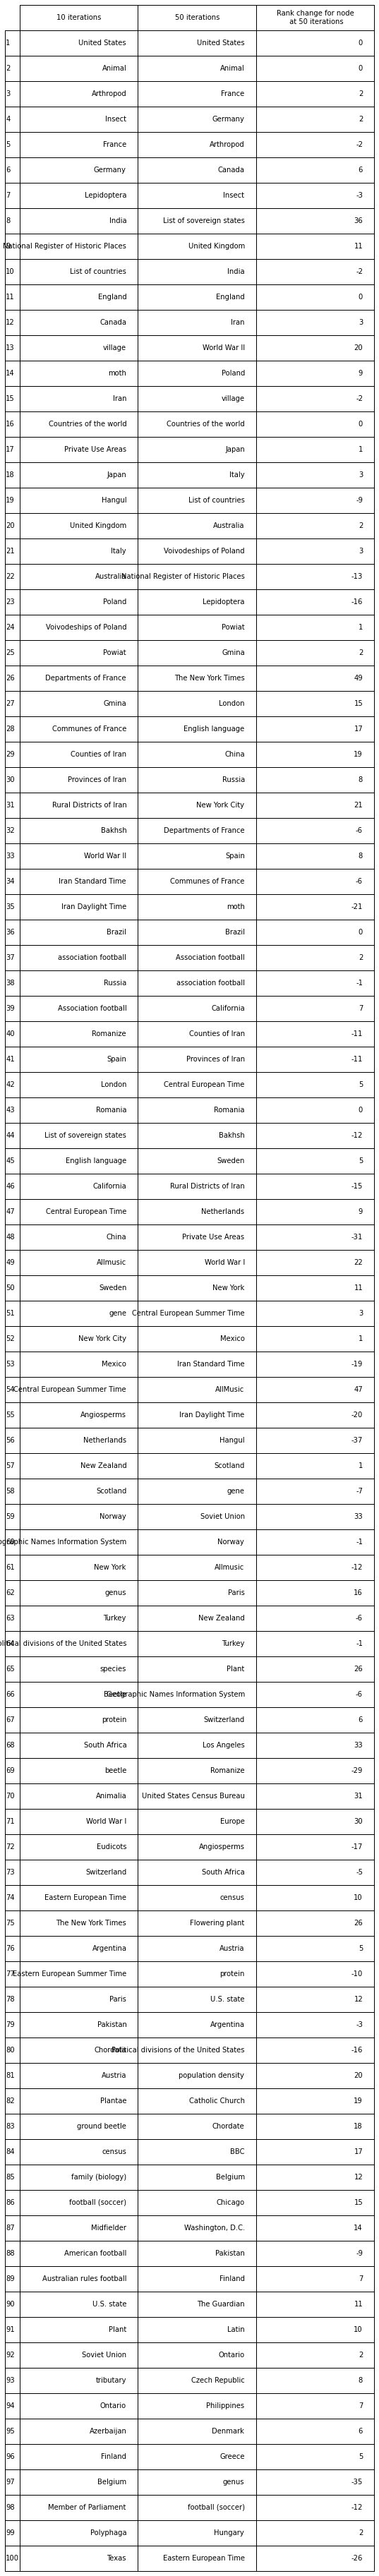

In [5]:
#plot the findings
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import ast

colLabels = ["10 iterations","50 iterations", "Rank change for node\n at 50 iterations"]
rowLabels=list(range(1, 101, 1))

#fill in ranking from both iterations
myData = np.empty((100,3), dtype=object)

#variables for storing the node name for 10 and 50 iteration modes
nodenames_10 = []
nodenames_50 = []

#add the node names of top 100 ranked nodes for 10-iteration case to data
with open('result10Itr','r') as nodescores_10runs:
    for i, nodescore_10 in enumerate(nodescores_10runs):
        (nodename_10,score_10) = nodescore_10.split("\t")
        myData[i][0] = nodename_10
        nodenames_10.append(nodename_10)

#add the node names of the top 100 ranked nodes for 50-iteration case to data        
with open('result50Itr','r') as nodescores_50runs:
    for i, nodescore_50 in enumerate(nodescores_50runs):
        (nodename_50,score_50) = nodescore_50.split("\t")
        myData[i][1] = nodename_50
        nodenames_50.append(nodename_50)

for i, nodename_50 in enumerate(nodenames_50):
    if nodename_50 not in nodenames_10:
        myData[i][2] = 100-i
    else:
        index_10 = nodenames_10.index(nodename_50)
        myData[i][2] = index_10-i
        

ax = plt.subplot(111,frame_on=False)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
myTable = plt.table(cellText=myData, rowLabels = rowLabels, colLabels=colLabels, loc='center')

#myTable.scale(3,3)
myTable.auto_set_font_size(False)
myTable.set_fontsize(10)
myTable.scale(3, 3)  # may help
myTable.properties()

#set width
prop = myTable.properties()
cells = prop['child_artists']
for cell in cells:
    cell.set_width(0.5)

plt.show()

50 iteration result seem to improve on the on the accuracy of the result compared to the 10 iterations. For example, we see relevant topic such as France bump up in the ranking and irrelvant topic such as Arthropod decline in ranking.

##13.3.10 Creating plot of PageRank score between 10 and 50-iteration cases

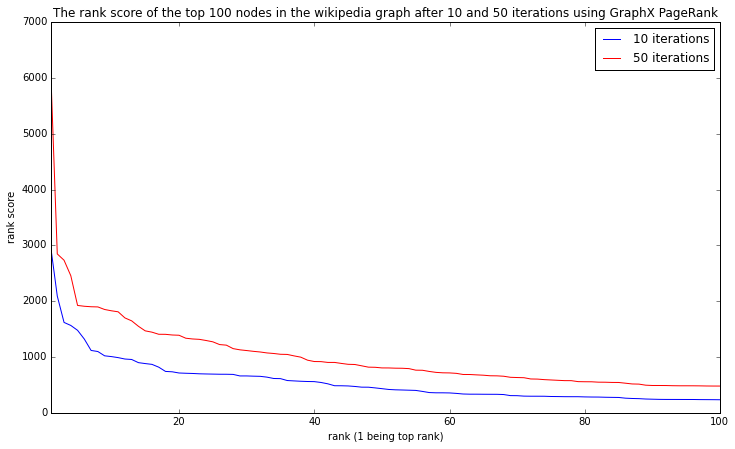

In [8]:
#plot it
%matplotlib inline
import math

#store the log of the rank scores for 10 and 50 iteration cases
score_10_arr=[]
score_50_arr=[]

#add the log(score) of top 100 ranked nodes for 10-iteration case to data
with open('result10Itr','r') as nodescores_10runs:
    for i, nodescore_10 in enumerate(nodescores_10runs):
        (nodename_10,score_10) = nodescore_10.split("\t")
        score_10_arr.append(float(score_10))

#add the log(score) of the top 100 ranked nodes for 50-iteration case to data        
with open('result50Itr','r') as nodescores_50runs:
    for i, nodescore_50 in enumerate(nodescores_50runs):
        (nodename_50,score_50) = nodescore_50.split("\t")
        score_50_arr.append(float(score_50))

#plot graph
ranks = list(range(1, 101, 1)) 
plt.figure(figsize=(12, 7))
plt.title('The rank score of the top 100 nodes in the wikipedia graph after 10 and 50 iterations using GraphX PageRank')
plt.ylabel('rank score')
plt.xlabel('rank (1 being top rank)')
plt.xlim(1,100)
#legend tutorial: http://matplotlib.org/users/legend_guide.html#plotting-guide-legend
line_10,=plt.plot(ranks, score_10_arr, 'b')
line_50,=plt.plot(ranks, score_50_arr, 'r')
plt.legend([line_10, line_50], ['10 iterations', '50 iterations'])
plt.show() 

It seems that running more iteration brought more weights to the topics that should get more weights, making ranking more "confident"

##13.3.11 Report AWS cluster configuration and performance
instance-type: m3.xlarge<br/>
instance-count: 6

#### 10 iterations
execution time: ~8 minutes

#### 50 iterations:
execution time: ~30 minutes

<table>
<tr>
<td><b>Implementation and Environment</b></td>
<td><b>10 iterations</b></td>
<td><b>50 iterations</b></td>
</tr>
<tr>
<td>GraphX PageRank (10 m3.xlarge)
</td>
<td>~8 minutes</td>
<td>~30 minutes</td>
</tr>
<tr>
<td>Home Grown PageRank (6 m3.xlarge)
</td>
<td>~50 minutes</td>
<td>~250 minutes</td>
</tr>
</table>

We believe there is a bug in our Home Grown PageRank, in that it is running 50 iterations even though we are telling it to run only 10 times. This is apparent in the 13.2 result since pageranks are identical between 10 and 50 iterations. We feel this explains why our Home Grown PageRank has such a worse performance compared to GraphX version. 

##13.3.12 Comment on findings about whether 100 ranked pages and PageRank score changed
It seems that homegrown pagrank after both 10 and 50 iterations match result from 50 iterations using GraphX PageRank. This means that our homegrown algorithm itself is identical to the GraphX version in terms of validity. However, as we stated as above, had we had more time we will investigate why our homegrown pagerank seems to be running 50 iterations when we tell it to run 10 iterations.

# HW 13.4: Criteo Phase 2 Baseline
>SPECIAL NOTE:
Please share your findings as they become available with the class via the Google Group. You will get brownie points for this.  Once results are shared, please use them and build on them.

>The  Criteo data is located in the following S3 bucket:  criteo-dataset 
https://console.aws.amazon.com/s3/home?region=us-west-1#&bucket=criteo-dataset&prefix=

>Using the training dataset, validation dataset, and testing dataset in the Criteo bucket, perform the following experiment:

>Write spark code (borrow from Phase 1 of this project) to train a logistic regression model with the following hyperparameters:

> - Number of buckets for hashing: 1,000
 - Logistic Regression: no regularization term
 - Logistic Regression: step size = 10

>Report the AWS cluster configuration that you used and how long in minutes and seconds it takes to complete this job.

>Report in tabular form the AUC value (https://en.wikipedia.org/wiki/Receiver_operating_characteristic) for the Training, Validation, and Testing datasets.  Report in tabular form  the logLossTest for the Training, Validation, and Testing datasets.

>Dont forget to put a caption on your tables (above each table).

## 13.4.1  Define Functions for Running Logistic Regression for Criteo Phase 2

In [10]:
%%writefile criteo_phase2.py
#!/usr/bin/env python
import sys
from pyspark import SparkContext
import numpy as np
from math import log
from math import exp
import hashlib
from collections import defaultdict
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.linalg import SparseVector
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.mllib.classification import LogisticRegressionWithSGD
import csv
import ast
import json
import time

def hashFunction(numBuckets, rawFeats, printMapping=False):
    """Calculate a feature dictionary for an observation's features based on hashing.

    Note:
        Use printMapping=True for debug purposes and to better understand how the hashing works.

    Args:
        numBuckets (int): Number of buckets to use as features.
        rawFeats (list of (int, str)): A list of features for an observation.  Represented as
            (featureID, value) tuples.
        printMapping (bool, optional): If true, the mappings of featureString to index will be
            printed.

    Returns:
        dict of int to float:  The keys will be integers which represent the buckets that the
            features have been hashed to.  The value for a given key will contain the count of the
            (featureID, value) tuples that have hashed to that key.
    """
    mapping = {}
    for ind, category in rawFeats:
        featureString = category + str(ind)
        mapping[featureString] = int(int(hashlib.md5(featureString).hexdigest(), 16) % numBuckets)
    if(printMapping): print mapping
    sparseFeatures = defaultdict(float)
    for bucket in mapping.values():
        sparseFeatures[bucket] += 1.0
    
    return dict(sparseFeatures)


def parseHashPoint(point, numBuckets):
    """Create a LabeledPoint for this observation using hashing.

    Args:
        point (str): A comma separated string where the first value is the label and the rest are
            features.
        numBuckets: The number of buckets to hash to.

    Returns:
        LabeledPoint: A LabeledPoint with a label (0.0 or 1.0) and a SparseVector of hashed
            features.
    """
    values = [x for x in point.split(",")]
    num_features = len(values) - 1
    x = []
    for i in range(num_features):
        x.append((i, values[i+1]))
    features = SparseVector(numBuckets,hashFunction(numBuckets, x, False))
        
    return LabeledPoint(values[0], features)


def getP(x, w, intercept):
    """Calculate the probability for an observation given a set of weights and intercept.

    Note:
        We'll bound our raw prediction between 20 and -20 for numerical purposes.

    Args:
        x (SparseVector): A vector with values of 1.0 for features that exist in this
            observation and 0.0 otherwise.
        w (DenseVector): A vector of weights (betas) for the model.
        intercept (float): The model's intercept.

    Returns:
        float: A probability between 0 and 1.
    """
    rawPrediction = x.dot(w) + intercept

    # Bound the raw prediction value
    rawPrediction = min(rawPrediction, 20)
    rawPrediction = max(rawPrediction, -20)
    
    return 1.0/(1 + exp(-1.0*rawPrediction))


def computeLogLoss(p, y):
    """Calculates the value of log loss for a given probability and label.

    Note:
        log(0) is undefined, so when p is 0 we need to add a small value (epsilon) to it
        and when p is 1 we need to subtract a small value (epsilon) from it.

    Args:
        p (float): A probabilty between 0 and 1.
        y (int): A label.  Takes on the values 0 and 1.

    Returns:
        float: The log loss value.
    """
    epsilon = 10e-12
    p = np.maximum(epsilon, p)
    p = np.minimum(1-epsilon, p)
    logLoss = y*np.log(p) + (1 - y)*np.log(1 - p)
    logLoss = logLoss * -1.0
    
    return logLoss


def evaluateResults(model, data):
    """Calculates the log loss and AUC for the data given the model.

    Args:
        model (LogisticRegressionModel): A trained logistic regression model.
        data (RDD of LabeledPoint): Labels and features for each observation.

    Returns:
        float: Log loss for the data.
    """
    predictionWithLabel = (data.map(lambda x: (getP(x.features, model.weights, model.intercept), x.label)))
    logLoss     = (predictionWithLabel
                   .map(lambda x: computeLogLoss(x[0], x[1]))
                   .reduce(lambda a, b: a + b)
                  )/predictionWithLabel.count()
    metrics = BinaryClassificationMetrics(predictionWithLabel)
    auc = metrics.areaUnderROC
    
    return logLoss, auc


def main_lr_model(input_train, input_val, input_test, output_file, splitData, hashData,  \
                  numHashBuckets, stepSizes, regParams, regType, includeIntercept):

    if splitData == 'True':
        splitData = True
    else:
        splitData = False
    if hashData == 'True':
        hashData = True
    else:
        hashData = False
    if regType == 'None':
        regType = None
    if includeIntercept == 'True':
        includeIntercept = True
    else:
        includeIntercept = False
      
    # get data from file, split if splitData = True, hash if hashData = True
    
    # read in train data
    # work with either ',' or '\t' separated data
    rawTrainData = (sc.textFile(input_train).map(lambda x: x.replace('\t', ',')))
    rawTrainData.cache()
    
    if input_val != 'None':
        rawValidationData = (sc.textFile(input_val).map(lambda x: x.replace('\t', ',')))
        rawValidationData.cache()
    
    if input_test != 'None':
        rawTestData = (sc.textFile(input_test).map(lambda x: x.replace('\t', ',')))
        rawTestData.cache()
    
    if splitData == True or input_val == 'None' or input_test == 'None':
        
        # split the raw data into training, validation, and test datasets
        weights = [.8, .1, .1]
        seed = 42

        rawTrainData, rawValidationData, rawTestData = rawTrainData.randomSplit(weights, seed)
        rawTrainData.cache()
        rawValidationData.cache()
        rawTestData.cache()

#     final_outputs=[]
    final_outputs=sc.emptyRDD()
    run_count = 0
        
    if hashData == True:
        for numHashBucket in numHashBuckets:

            # hash the data
            hashTrainData = rawTrainData.map(lambda point: parseHashPoint(point,numHashBucket))
            hashTrainData.cache()
            hashValidationData = rawValidationData.map(lambda point: parseHashPoint(point,numHashBucket))
            hashValidationData.cache()
            hashTestData = rawTestData.map(lambda point: parseHashPoint(point,numHashBucket))
            hashTestData.cache()

            for stepSize in stepSizes:
                for regParam in regParams:
        
                    # test hyperparameters: stepSize, regParam, regType, includeIntercept
                    # output: log loss and AUC for training, validation, and test datasets
                        
                    # build logistic regression model
                    model = (LogisticRegressionWithSGD
                                .train(hashTrainData, step = stepSize, regParam = regParam,  \
                                       regType=regType, intercept=includeIntercept))

                    # evaluate the model
                    logLossTrain, aucTrain = evaluateResults(model, hashTrainData)
                    logLossVal, aucVal = evaluateResults(model, hashValidationData)
                    logLossTest, aucTest = evaluateResults(model, hashTestData)
    
                    output_line = (numHashBucket, stepSize, regParam, regType, includeIntercept, logLossTrain, 
                                   aucTrain,logLossVal, aucVal, logLossTest, aucTest)

                    run_count+=1               

                    output_rdd = sc.parallelize([(run_count,output_line)])
                    final_outputs = final_outputs.union(output_rdd)
                        
    else:
        for stepSize in stepSizes:        
            for regParam in regParams:
                        
                # test hyperparameters: stepSize, regParam, regType, includeIntercept
                # output: log loss and AUC for training, validation, and test datasets
                        
                # build logistic regression model
                model = (LogisticRegressionWithSGD
                            .train(hashTrainData, step = stepSize, regParam = regParam,  \
                                   regType=regType, intercept=includeIntercept))

                # evaluate the model
                logLossTrain, aucTrain = evaluateResults(model, hashTrainData)
                logLossVal, aucVal = evaluateResults(model, hashValidationData)
                logLossTest, aucTest = evaluateResults(model, hashTestData)
    
                #configure output
                output_line = (stepSize, regParam, regType, includeIntercept, logLossTrain, 
                               aucTrain,logLossVal, aucVal, logLossTest, aucTest)
                run_count+=1               
                output_rdd = sc.parallelize([(run_count,output_line)])
                final_outputs = final_outputs.union(output_rdd)

    #save output
    final_outputs.sortByKey(True).coalesce(1).saveAsTextFile(output_file)

    return


if __name__ == "__main__":
    
    #obtain data from json input
    sc = SparkContext(appName="criteo_phase2") 
    
    input_data = sc.textFile(sys.argv[1]).map(lambda line: json.loads(line)).collect()[0]
 
    if input_data["splitData"]=="True": input_data["splitData"]==True
    else: input_data["splitData"]=False
    
    if input_data["hashData"]=="True": input_data["hashData"]==True
    else: input_data["hashData"]=False
        
    if input_data["regType"]=="None": input_data["regType"]=None

    if input_data["includeIntercept"]=="True": input_data["includeIntercept"]==True
    else: input_data["includeIntercept"]=False    

    main_lr_model(input_data["input_train"], 
                  input_data["input_val"], 
                  input_data["input_test"], 
                  input_data["output_file"], 
                  input_data["splitData"], 
                  input_data["hashData"],
                  input_data["numHashBuckets"],
                  input_data["stepSize"],
                  input_data["regParam"],
                  input_data["regType"], 
                  input_data["includeIntercept"]
    )

    sc.stop()

Writing criteo_phase2.py


## 13.4.2 Run Criteo Phase 2 with Small Test Dataset Locally (No Regularization)
We will first do dry run with very small data set with various number of buckets, reg params, etc.. to make sure code works.

In [11]:
%%writefile 13_4_dummy_local.json
{
    "input_train"      : "dac_sample.txt",
    "input_val"        : "None",
    "input_test"       : "None",
    "output_file"      : "13_4/output_dummy_local/",
    "splitData"        : "True",
    "hashData"         : "True",
    "numHashBuckets"   : [1000],
    "stepSize"         : [100],
    "regParam"         : [1e-3],
    "regType"          : "None",
    "includeIntercept" : "True"
}

Writing 13_4_dummy_local.json


In [ ]:
#must minify the json file so that it is a single line in order to be fed into Spark
!python -m jsmin 13_4_dummy_local.json > 13_4_dummy_local_mini.json

In [ ]:
# ensure folder with output name does not exist
!rm -r 13_4/output_dummy_local 

#submit spark job
!time /Users/maktrix/Dropbox/Berkeley/W261_ML_scale/spark-1.5.1-bin-hadoop2.6/bin/spark-submit ./criteo_phase2.py 13_4_dummy_local_mini.json 
    
# output results:
# results are: numHashBuckets, stepSize, regParam, regType, includeIntercept, logLossTrain, aucTrain,
#              logLossValidation, aucValidation, logLossTest, aucTest
# !rm 13_4/local_output/_SUCCESS
!echo 'Output is in the form: (numHashBuckets, (stepSize, regParam, regType, includeIntercept, logLossTrain, aucTrain, \
              logLossValidation, aucValidation, logLossTest, aucTest))'
!echo '-----------------OUTPUT-----------------'
!cat 13_4/output_dummy_local/part-00000

In [ ]:
# ensure folder with output name does not exist
!rm -r 13_4/output_dummy_local 

#submit spark job
!time /Users/maktrix/Dropbox/Berkeley/W261_ML_scale/spark-1.5.1-bin-hadoop2.6/bin/spark-submit ./criteo_phase2.py 13_4_dummy_local_mini.json 
    
# output results:
# results are: numHashBuckets, stepSize, regParam, regType, includeIntercept, logLossTrain, aucTrain,
#              logLossValidation, aucValidation, logLossTest, aucTest
# !rm 13_4/local_output/_SUCCESS
!echo 'Output is in the form: (case_number, (numHashBuckets, stepSize, regParam, regType, includeIntercept, logLossTrain, aucTrain, \
              logLossValidation, aucValidation, logLossTest, aucTest))'
!echo '-----------------OUTPUT-----------------'
!cat 13_4/output_dummy_local/part-00000

In [ ]:
# ("case_number", ("numHashBuckets", "stepSize", "regParam", "regType", "includeIntercept", "logLossTrain", "aucTrain","logLossValidation", "aucValidation", "logLossTest", "aucTest"))
#-----------------OUTPUT-----------------
#(1, (1000, 100, 0.001, None, True, 2.5322448153076667, 0.746488801117319, 2.625150108494088, 0.7356406890864063, 2.6037791705678957, 0.7345233841682506))

## 13.4.3  Run Criteo Phase 2 with Small Test Dataset on EMR Cluster (no regularization)

In [ ]:
#create cluster
!aws emr create-cluster --name "13_4" --release-label emr-4.2.0 --applications Name=Spark --instance-count 10 --use-default-roles --ec2-attributes KeyName=w261_key2 --instance-type m3.xlarge  --enable-debugging --log-uri s3://ucb-mids-mls-group-e/hw13 --configurations file://./emr_config_spark_max.json

In [ ]:
%%writefile 13_4_dummy_emr.json
{
    "input_train"      : "s3n://ucb-mids-mls-group-e/hw13/13_4/dac_sample.txt",
    "input_val"        : "None",
    "input_test"       : "None",
    "output_file"      : "s3n://ucb-mids-mls-group-e/hw13/13_4/output_dummy_emr",
    "splitData"        : "True",
    "hashData"         : "True",
    "numHashBuckets"   : [1000,10000],
    "stepSize"         : [10,100],
    "regParam"         : [1e-6, 1e-3],
    "regType"          : "None",
    "includeIntercept" : "True"
}

In [ ]:
#must minify the json file so that it is a single line in order to be fed into Spark
!python -m jsmin 13_4_dummy_emr.json > 13_4_dummy_emr_mini.json

In [ ]:
#copy dummy small test data and json input file to s3
!aws s3 cp dac_sample.txt s3://ucb-mids-mls-group-e/hw13/13_4/dac_sample.txt
!aws s3 cp 13_4_dummy_emr_mini.json s3://ucb-mids-mls-group-e/hw13/13_4/13_4_dummy_emr_mini.json

In [ ]:
#copy main pyspark file to emr cluster
!scp -i /Users/maktrix/Dropbox/Berkeley/W261_ML_scale/w261_key2.pem criteo_phase2.py hadoop@ec2-52-33-135-218.us-west-2.compute.amazonaws.com:code/.

In [ ]:
#make sure output folder of same name does not exist
!aws s3 rm --recursive s3://ucb-mids-mls-group-e/hw13/13_4/output_dummy_emr

#### Run job on EMR by ssh into the cluster and submit spark job with below commands:
- ssh -i w261_key2.pem hadoop@ec2-52-11-63-26.us-west-2.compute.amazonaws.com
- time /usr/lib/spark/bin/spark-submit --master yarn-cluster ./code/criteo_phase2.py s3n://ucb-mids-mls-group-e/hw13/13_4/13_4_dummy_emr_mini.json

In [ ]:
#remove local output folder of same name
!rm -r 13_4/output_dummy_emr

#get output from S3 (note that there is only one partition because of spark's colesce function
!aws s3 cp --recursive s3://ucb-mids-mls-group-e/hw13/13_4/output_dummy_emr 13_4/output_dummy_emr
    
!echo 'Output is in the form: (case_number, (numHashBuckets, stepSize, regParam, regType, includeIntercept, logLossTrain, aucTrain, \
              logLossValidation, aucValidation, logLossTest, aucTest))'
!echo '-----------------OUTPUT-----------------'
!cat 13_4/output_dummy_emr/part-00000

In [ ]:
# ("case_number", ("numHashBuckets", "stepSize", "regParam", "regType", "includeIntercept", "logLossTrain", "aucTrain","logLossValidation", "aucValidation", "logLossTest", "aucTest"))
# -----------------OUTPUT-----------------
# (1, (1000, 10, 9.9999999999999995e-07, None, True, 0.46420700188039676, 0.74666074359407864, 0.46366004113163489, 0.73875346872407011, 0.47165704683646043, 0.73518732270835574))
# (2, (1000, 10, 0.001, None, True, 0.46420700188039676, 0.74666074359407808, 0.46366004113163489, 0.73875346872406988, 0.47165704683646043, 0.73518732270835585))
# (3, (1000, 100, 9.9999999999999995e-07, None, True, 2.5322448153076667, 0.74648880111732496, 2.6251501084940876, 0.73564068908640778, 2.6037791705678952, 0.73452338416825214))
# (4, (1000, 100, 0.001, None, True, 2.5322448153076667, 0.74648880111732496, 2.6251501084940876, 0.73564068908640767, 2.6037791705678952, 0.73452338416825225))
# (5, (10000, 10, 9.9999999999999995e-07, None, True, 0.45387642369978287, 0.76367286716070537, 0.45530126025911888, 0.75247243508757933, 0.46268514365324975, 0.75048209297820989))
# (6, (10000, 10, 0.001, None, True, 0.45387642369978287, 0.76367286716070404, 0.45530126025911888, 0.75247243508757899, 0.46268514365324975, 0.75048209297820989))
# (7, (10000, 100, 9.9999999999999995e-07, None, True, 0.77740302275906248, 0.77269962241834955, 0.82077510399856646, 0.75238595704337119, 0.82554924901862681, 0.7508525725504106))
# (8, (10000, 100, 0.001, None, True, 0.77740302275906248, 0.77269962241834966, 0.82077510399856646, 0.75238595704337174, 0.82554924901862681, 0.75085257255041127))

## 13.4.4  Run Criteo Phase 2 with Full Dataset on EMR Cluster (no regularization)
Note that only the specified case of 1000 hash bucket and step size of 10 is being run. 

In [ ]:
%%writefile 13_4_full_emr.json
{
    "input_train"      : "s3n://criteo-dataset/rawdata/train",
    "input_val"        : "s3n://criteo-dataset/rawdata/validation",
    "input_test"       : "s3n://criteo-dataset/rawdata/test",
    "output_file"      : "s3n://ucb-mids-mls-group-e/hw13/13_4/output_full_emr",
    "splitData"        : "False",
    "hashData"         : "True",
    "numHashBuckets"   : [1000],
    "stepSize"         : [10],
    "regParam"         : [1e-6],
    "regType"          : "None",
    "includeIntercept" : "True"
}

In [ ]:
#must minify the json file so that it is a single line in order to be fed into Spark
!python -m jsmin 13_4_full_emr.json > 13_4_full_emr_mini.json

#copy json input file to s3
!aws s3 cp 13_4_full_emr_mini.json s3://ucb-mids-mls-group-e/hw13/13_4/13_4_full_emr_mini.json
    
#copy main PySpark file into EMR master node
!scp -i /Users/maktrix/Dropbox/Berkeley/W261_ML_scale/w261_key2.pem criteo_phase2.py hadoop@ec2-52-33-135-218.us-west-2.compute.amazonaws.com:code/.

#make sure no output folder of same name exist
!aws s3 rm --recursive s3://ucb-mids-mls-group-e/hw13/13_4/output_full_emr

#### Run job on EMR by ssh into the cluster and submit spark job with below commands:
- ssh -i w261_key2.pem hadoop@ec2-52-11-63-26.us-west-2.compute.amazonaws.com
- time /usr/lib/spark/bin/spark-submit --master yarn-cluster ./code/criteo_phase2.py s3n://ucb-mids-mls-group-e/hw13/13_4/13_4_full_emr_mini.json

Runtime:   
real	32m5.550s  
user	0m10.396s  
sys	0m1.312s  

In [ ]:
#remove local output folder of same name
!rm -r 13_4/output_full_emr

#get output from S3 (note that there is only one partition because of spark's colesce function
!aws s3 cp --recursive s3://ucb-mids-mls-group-e/hw13/13_4/output_full_emr 13_4/output_full_emr
    
!echo 'Output is in the form: (case_number, (numHashBuckets, stepSize, regParam, regType, includeIntercept, logLossTrain, aucTrain, \
              logLossValidation, aucValidation, logLossTest, aucTest))'
!echo '-----------------OUTPUT-----------------'
!cat 13_4/output_full_emr/part-00000

In [ ]:
# ("case_number", ("numHashBuckets", "stepSize", "regParam", "regType", "includeIntercept", "logLossTrain", "aucTrain","logLossValidation", "aucValidation", "logLossTest", "aucTest"))
# -----------------OUTPUT-----------------
# (1, (1000, 10, 9.9999999999999995e-07, None, True, 0.50546399695096322, 0.72454929493843867, 0.50567611207609031, 0.72432606212044237, 0.50560280035162408, 0.72479664734688976))

## 13.4.5 Report Results
This is the final result of the actual EMR run on the full set of Criteo data. We used the raw data (NOT the preprocessed data) so that we can hash it to 1000 buckets. The main task for hw13.4 includes the following configurations:
-    "input_train"      : "s3n://criteo-dataset/rawdata/train",
-    "input_val"        : "s3n://criteo-dataset/rawdata/validation",
-    "input_test"       : "s3n://criteo-dataset/rawdata/test",
-    "output_file"      : "s3n://ucb-mids-mls-group-e/hw13/13_4/output_full_emr",
-    "splitData"        : "False",
-    "hashData"         : "True",
-    "numHashBuckets"   : [1000],
-    "stepSize"         : [10],
-    "regParam"         : [1e-6],
-    "regType"          : "None",
-    "includeIntercept" : "True"

In [12]:
from prettytable import PrettyTable

x = PrettyTable(["Data", "Log Loss", "AUC"])
# x.align["City name"] = "l" # Left align city names
x.padding_width = 1 # One space between column edges and contents (default)
x.add_row(["Train",0.5055, 0.7245])
x.add_row(["Validation",0.5057, 0.7243])
x.add_row(["Test", 0.5056, 0.7248])
print x

+------------+----------+--------+
|    Data    | Log Loss |  AUC   |
+------------+----------+--------+
|   Train    |  0.5055  | 0.7245 |
| Validation |  0.5057  | 0.7243 |
|    Test    |  0.5056  | 0.7248 |
+------------+----------+--------+


The EMR cluster configuration is as follow:
- instance-type: m3.xlarge  
- instance-count: 10
- region: us-west-2
- execution time: 32m5.550s \*

\* We used the elapsed real time between command line invocation and termination as our time benchmark for execution time

# HW 13.5: Criteo Phase 2 Hyperparameter Tuning
>SPECIAL NOTE:
Please share your findings as they become available with class via the Google Group. You will get brownie points for this.  Once results are shared please used them and build on them.

>NOTE:  please do  HW 13.5 in groups of 3 

>Using the training dataset, validation dataset and testing dataset in the Criteo bucket perform the following experiments:

>-- write spark code (borrow from Phase 1 of this project) to train a logistic regression model with various hyperparamters. Do a gridsearch of the hyperparameter space and determine optimal settings using the validation set.

>-- Number of buckets for hashing: 1,000, 10,000, .... explore different values  here
-- Logistic Regression: regularization term: [1e-6, 1e-3]  explore other  values here also
-- Logistic Regression: step size: explore different step sizes. Focus on a stepsize of 1 initially. 

>Report the AWS cluster configuration that you used and how long in minutes and seconds it takes to complete this job.

>Report in tabular form and using heatmaps the AUC values (https://en.wikipedia.org/wiki/Receiver_operating_characteristic) for the Training, Validation, and Testing datasets.
Report in tabular form and using heatmaps  the logLossTest for the Training, Validation, and Testing datasets.

>Dont forget to put a caption on your tables (above the table) and on your heatmap figures (put caption below figures) detailing the experiment associated with each table or figure (data, algorithm used, parameters and settings explored.

>Discuss the optimal setting to solve this problem  in terms of the following:
-- Features
-- Learning algortihm
-- Spark cluster

>Justiy your recommendations based on your experimental results and cross reference with table numbers and figure numbers. Also highlight key results with annotations, both textual and line and box based, on your tables and graphs.


##13.5.1 Run cluster with 48 hyperparameter scenarios

In [ ]:
#create cluster
!aws emr create-cluster --name "13_5" --release-label emr-4.2.0 --applications Name=Spark --instance-count 22 --use-default-roles --ec2-attributes KeyName=w261_key2 --instance-type m3.xlarge  --enable-debugging --log-uri s3://ucb-mids-mls-group-e/hw13 --configurations file://./emr_config_spark_max.json

In [ ]:
%%writefile 13_5_full_emr.json
{
    "input_train"      : "s3n://criteo-dataset/rawdata/train",
    "input_val"        : "s3n://criteo-dataset/rawdata/validation",
    "input_test"       : "s3n://criteo-dataset/rawdata/test",
    "output_file"      : "s3n://ucb-mids-mls-group-e/hw13/13_5",
    "splitData"        : "False",
    "hashData"         : "True",
    "numHashBuckets"   : [1000,10000, 50000, 100000],
    "stepSize"         : [1, 10, 50, 100],
    "regParam"         : [1e-6, 1e-3, 1e-1],
    "regType"          : "l2",
    "includeIntercept" : "True"
}

In [ ]:
### must minify the json file so that it is a single line in order to be fed into Spark
!python -m jsmin 13_5_full_emr.json > 13_5_full_emr_mini.json

### copy json input file to s3
!aws s3 cp 13_5_full_emr_mini.json s3://ucb-mids-mls-group-e/hw13/13_5/13_5_full_emr_mini.json

### copy main PySpark file into EMR master node
!scp -i /Users/maktrix/Dropbox/Berkeley/W261_ML_scale/w261_key2.pem criteo_phase2.py hadoop@ec2-52-33-226-49.us-west-2.compute.amazonaws.com:code/.

### make sure no output folder of same name exist
!aws s3 rm --recursive s3://ucb-mids-mls-group-e/hw13/13_5/output_full_emr

#### Run job on EMR by ssh into the cluster and submit spark job with below commands:
- ssh -i w261_key2.pem hadoop@ec2-52-33-226-49.us-west-2.compute.amazonaws.com
- time /usr/lib/spark/bin/spark-submit --master yarn-cluster ./code/criteo_phase2.py s3n://ucb-mids-mls-group-e/hw13/13_5/13_5_full_emr_mini.json

In [ ]:
#remove local output folder of same name
!rm -r 13_5/output_full_emr

#get output from S3 (note that there is only one partition because of spark's colesce function
!aws s3 cp --recursive s3://ucb-mids-mls-group-e/hw13/13_5/output_full_emr 13_5/output_full_emr
    
!echo 'Output is in the form: (numHashBuckets, (stepSize, regParam, regType, includeIntercept, logLossTrain, aucTrain, \
              logLossValidation, aucValidation, logLossTest, aucTest))'
!echo '-----------------OUTPUT-----------------'
!echo '("case_number", ("numHashBuckets", "stepSize", "regParam", "regType", "includeIntercept", "logLossTrain", "aucTrain","logLossValidation", "aucValidation", "logLossTest", "aucTest"))'
!cat 13_5/output_full_emr/part-00000

In [ ]:
# ("case_number", ("numHashBuckets", "stepSize", "regParam", "regType", "includeIntercept", "logLossTrain", "aucTrain","logLossValidation", "aucValidation", "logLossTest", "aucTest"))
#-----------------OUTPUT-----------------
# (1, (1000, 1, 9.9999999999999995e-07, u'l2', True, 0.52336210847317366, 0.69727235904455021, 0.52357713462466937, 0.69706608495238132, 0.52346631835087509, 0.69765682518708938))
# (2, (1000, 1, 0.001, u'l2', True, 0.52349307216426577, 0.697225330169019, 0.52370770983046744, 0.69701940597447054, 0.52359805806452475, 0.69760994952124444))
# (3, (1000, 1, 0.10000000000000001, u'l2', True, 0.53704458765235852, 0.68895203126711257, 0.53724148816951678, 0.68874235782319237, 0.53719793010055117, 0.68935052941140307))
# (4, (1000, 10, 9.9999999999999995e-07, u'l2', True, 0.5054643594619106, 0.724548685425773, 0.50567647833274854, 0.72432544063149451, 0.50560316192900534, 0.72479604047460566))
# (5, (1000, 10, 0.001, u'l2', True, 0.50573010021831544, 0.724190398037033, 0.50594099786837776, 0.72396648673120567, 0.50586551772200861, 0.72444937392339825))
# (6, (1000, 10, 0.10000000000000001, u'l2', True, 0.54288611295792544, 0.69584772488457147, 0.54303615874973754, 0.69570346452488019, 0.54297714485871251, 0.69624464227203431))
# (7, (1000, 50, 9.9999999999999995e-07, u'l2', True, 1.187135784935007, 0.72140619540694839, 1.1872807082064689, 0.72125919640135783, 1.1864043897332217, 0.72157726137454925))
# (8, (1000, 50, 0.001, u'l2', True, 1.2682623755753999, 0.71545614175256511, 1.2692281280416526, 0.71515624339159567, 1.2691728989456257, 0.71572845051018552))
# (9, (1000, 50, 0.10000000000000001, u'l2', True, 5.1222424435665994, 0.50100092769258275, 5.1257073472823969, 0.50102795097249897, 5.1282412577055076, 0.50105962090296519))
# (10, (1000, 100, 9.9999999999999995e-07, u'l2', True, 3.2183125416137752, 0.72301210911684977, 3.2188583098397521, 0.72287515043464012, 3.2156735378490344, 0.72323035750320885))
# (11, (1000, 100, 0.001, u'l2', True, 4.6678058167324581, 0.7168429328607433, 4.6673703651203233, 0.71675608273996239, 4.6638156346795121, 0.71715886626599268))
# (12, (1000, 100, 0.10000000000000001, u'l2', True, 14.781848900695556, 0.50352373977573206, 14.778404895220124, 0.50339450627338767, 14.77623101768024, 0.50316382500168721))
# (13, (10000, 1, 9.9999999999999995e-07, u'l2', True, 0.52172593457177407, 0.70083529873144046, 0.52190435897403253, 0.70071857155967354, 0.52186206521968959, 0.7011386290291447))
# (14, (10000, 1, 0.001, u'l2', True, 0.52186699734136266, 0.70078310353268225, 0.5220453146752102, 0.70066653466264206, 0.52200371077080343, 0.70108661221632518))
# (15, (10000, 1, 0.10000000000000001, u'l2', True, 0.53624784626689836, 0.69179484513614198, 0.53642206168514073, 0.69167525762151416, 0.53641951689291922, 0.69211421801271233))
# (16, (10000, 10, 9.9999999999999995e-07, u'l2', True, 0.49747807400134791, 0.73790331271353093, 0.49764332326163413, 0.737721358332457, 0.49767631332488327, 0.73798232479219827))
# (17, (10000, 10, 0.001, u'l2', True, 0.49822433337767352, 0.7370907893155948, 0.49838918496119428, 0.73690979135156831, 0.49841839104011854, 0.73718083077234009))
# (18, (10000, 10, 0.10000000000000001, u'l2', True, 0.53492920963113633, 0.69612475102313565, 0.53510172117158561, 0.69600731733718979, 0.53510314439788909, 0.69643364674634722))
# (19, (10000, 50, 9.9999999999999995e-07, u'l2', True, 1.5748248996527081, 0.74142435809010165, 1.5745551562718469, 0.7412926800592593, 1.5737785948228566, 0.74144952463746128))
# (20, (10000, 50, 0.001, u'l2', True, 1.5073774218000948, 0.73663370755603674, 1.5069792940893629, 0.73651200092353875, 1.5062760325471767, 0.73673475748594919))
# (21, (10000, 50, 0.10000000000000001, u'l2', True, 0.78293134831225175, 0.65867663307183333, 0.78348090172771634, 0.65851926759388413, 0.78354934153844169, 0.65902064895046553))
# (22, (10000, 100, 9.9999999999999995e-07, u'l2', True, 2.6477054592814517, 0.74030906463472579, 2.6472299160100152, 0.74018416125738595, 2.6461954981243636, 0.74033600882627071))
# (23, (10000, 100, 0.001, u'l2', True, 5.114001261660059, 0.50580665788631551, 5.1173524559697432, 0.50584664102388222, 5.119696238619837, 0.50599802732586241))
# (24, (10000, 100, 0.10000000000000001, u'l2', True, 14.157753292461713, 0.51736516239100794, 14.154232242706234, 0.51759635819850258, 14.15233015119065, 0.51713097585950185))
# (25, (50000, 1, 9.9999999999999995e-07, u'l2', True, 0.52163256410982628, 0.70117452050131823, 0.52180459350229103, 0.70108079302901705, 0.52176068954404209, 0.70150526727575446))
# (26, (50000, 1, 0.001, u'l2', True, 0.52177590666299778, 0.70111946491405663, 0.52194790496588528, 0.70102580363612088, 0.52190468284521419, 0.70145037982435388))
# (27, (50000, 1, 0.10000000000000001, u'l2', True, 0.5362532051169665, 0.69192388795370818, 0.53642426372178453, 0.69182560256463366, 0.53642094272772778, 0.69226999910105835))
# (28, (50000, 10, 9.9999999999999995e-07, u'l2', True, 0.49697975024324187, 0.73879795902950307, 0.49714222378830181, 0.73859625953289931, 0.49715410311095137, 0.73890742131654708))
# (29, (50000, 10, 0.001, u'l2', True, 0.49778260406151686, 0.73793751824863585, 0.49794489086471011, 0.737738025581677, 0.49795377154688464, 0.73805790852940645))
# (30, (50000, 10, 0.10000000000000001, u'l2', True, 0.53493382119907362, 0.69624373845878396, 0.53510413638927767, 0.69614158753616084, 0.53510341587646515, 0.69657890043414372))
# (31, (50000, 50, 9.9999999999999995e-07, u'l2', True, 1.1078249808620797, 0.74385680940839405, 1.1076161664380753, 0.74368101694674749, 1.1070718723039776, 0.74391577006877796))
# (32, (50000, 50, 0.001, u'l2', True, 0.90920573485367573, 0.73133387540754857, 0.90991326466741607, 0.73108481860289698, 0.9099046322472818, 0.73147623437125964))
# (33, (50000, 50, 0.10000000000000001, u'l2', True, 0.77685738497138268, 0.65868788854142168, 0.77739319475771473, 0.65854771081562613, 0.77745284064647313, 0.65905336751944255))
# (34, (50000, 100, 9.9999999999999995e-07, u'l2', True, 2.4930071144368529, 0.74139632808419409, 2.4923866573693361, 0.74124864020567593, 2.4913048579520787, 0.74145700722776475))
# (35, (50000, 100, 0.001, u'l2', True, 5.0058033261196542, 0.54231336543441211, 5.0086456198971598, 0.54256189062365889, 5.0105638941205264, 0.54250186920954646))
# (36, (50000, 100, 0.10000000000000001, u'l2', True, 14.067906986909493, 0.51778208019293759, 14.064287711846703, 0.51795003855211508, 14.062508902282756, 0.51752285945425802))
# (37, (100000, 1, 9.9999999999999995e-07, u'l2', True, 0.52158654522227677, 0.70128324205276293, 0.52176293891951087, 0.70117759202171315, 0.52171530625174778, 0.70161209162559335))
# (38, (100000, 1, 0.001, u'l2', True, 0.52173014849541577, 0.7012280349702239, 0.5219064816259964, 0.70112243761658422, 0.52185955428664188, 0.70155705729785345))
# (39, (100000, 1, 0.10000000000000001, u'l2', True, 0.5362231419113983, 0.69202367957529498, 0.53639663666639237, 0.69191329159015236, 0.53639113568203356, 0.69236831901472129))
# (40, (100000, 10, 9.9999999999999995e-07, u'l2', True, 0.49686888930472667, 0.73899903682856471, 0.49704214235687738, 0.73878177442721149, 0.49704914524132404, 0.73910100813474444))
# (41, (100000, 10, 0.001, u'l2', True, 0.49768107238919185, 0.73812929125047644, 0.49785369700970888, 0.73791446564230812, 0.49785765890116068, 0.73824268947006366))
# (42, (100000, 10, 0.10000000000000001, u'l2', True, 0.53490553291263288, 0.69634162044806458, 0.53507846267006332, 0.69622677851475834, 0.53507539234976187, 0.69667543117825537))
# (43, (100000, 50, 9.9999999999999995e-07, u'l2', True, 0.70320010307302072, 0.74189582066630944, 0.70364257024256405, 0.74164862266059151, 0.70332093671213813, 0.74198807068128392))
# (44, (100000, 50, 0.001, u'l2', True, 0.9060223613565731, 0.73160443268294617, 0.90677364176682296, 0.73134218911211224, 0.90672291198917221, 0.73174020591746181))
# (45, (100000, 50, 0.10000000000000001, u'l2', True, 0.77651824220339927, 0.65879177243906739, 0.77705631447310375, 0.6586425337666888, 0.77711259650146858, 0.65915594035085612))
# (46, (100000, 100, 9.9999999999999995e-07, u'l2', True, 2.527650697921207, 0.74189476219710393, 2.5271080321802231, 0.74172023132540421, 2.5258924774938567, 0.74196840086039995))
# (47, (100000, 100, 0.001, u'l2', True, 5.119491197142251, 0.50255891881409409, 5.1229194509791158, 0.50257070947158977, 5.125344666199644, 0.50271228961779824))
# (48, (100000, 100, 0.10000000000000001, u'l2', True, 14.059246045331838, 0.51765415597179443, 14.05563256277973, 0.51784092404792137, 14.053807135386277, 0.51743233444015768))

## 13.5.2 Calculate maximum AUC and minimum Log Loss
First we calculated which setting produced the highest AUC and lowest logloss. 

In [19]:
allResults=[]

#variable for all of the mimimum/maximum and setting
#format:
#(value, num of buckets, stepSize, regParam)
LogLossTrainMin=(1000,0,0,0)
AUCTrainMax=(0,0,0,0)

LogLossValMin = (1000,0,0,0)
AUCValMax =(0,0,0,0)

LogLossTestMin = (1000,0,0,0)
AUCTestMax = (0,0,0,0)

index =0
with open("13_5/output_full_emr/part-00000") as f:
    for line in f.readlines():  
        
        #format (0'numHashBuckets', 1'stepSize', 2'regParam', 3'regType', 
        #4'includeIntercept', 5'logLossTrain', 6'aucTrain', 7'logLossValidation', 
        #8'aucValidation', 9'logLossTest', 10'aucTest')

#         if (index != 0): # skip the header row
        res = ast.literal_eval(line)[1]

        #replace min/max
        if res[5] < LogLossTrainMin[0]:
            LogLossTrainMin = (res[5],res[0],res[1],res[2])

        if res[6] > AUCTrainMax[0]:
            AUCTrainMax = (res[6],res[0],res[1],res[2])

        if res[7] < LogLossValMin[0]:
            LogLossValMin = (res[7],res[0],res[1],res[2])

        if res[8] > AUCValMax[0]:
            AUCValMax = (res[8],res[0],res[1],res[2])

        if res[9] < LogLossTestMin[0]:
            LogLossTestMin = (res[9],res[0],res[1],res[2])

        if res[10] > AUCTestMax[0]:
            AUCTestMax = (res[10],res[0],res[1],res[2])
#         index+=1
print LogLossTrainMin

print LogLossValMin

print LogLossTestMin


print AUCTrainMax
print AUCValMax
print AUCTestMax

(0.49686888930472667, 100000, 10, 1e-06)
(0.4970421423568774, 100000, 10, 1e-06)
(0.49704914524132404, 100000, 10, 1e-06)
(0.743856809408394, 50000, 50, 1e-06)
(0.7436810169467475, 50000, 50, 1e-06)
(0.743915770068778, 50000, 50, 1e-06)


### Maximum AUC

In [22]:
from prettytable import PrettyTable

x = PrettyTable(["Data", "Maximum AUC", "Hash Bucket Size","Step Size", "Reg Param"])
# x.align["City name"] = "l" # Left align city names
x.padding_width = 1 # One space between column edges and contents (default)
x.add_row(["Train",0.7439, 50000, 50,1e-06])
x.add_row(["Validation",0.7437, 50000, 50,1e-06])
x.add_row(["Test", 0.7439, 50000, 50,1e-06])
print x

+------------+-------------+------------------+-----------+-----------+
|    Data    | Maximum AUC | Hash Bucket Size | Step Size | Reg Param |
+------------+-------------+------------------+-----------+-----------+
|   Train    |    0.7439   |      50000       |     50    |   1e-06   |
| Validation |    0.7437   |      50000       |     50    |   1e-06   |
|    Test    |    0.7439   |      50000       |     50    |   1e-06   |
+------------+-------------+------------------+-----------+-----------+


###  Minimum Logloss

In [21]:
from prettytable import PrettyTable

x = PrettyTable(["Data", "Minimum Log Loss", "Hash Bucket Size","Step Size", "Reg Param"])
# x.align["City name"] = "l" # Left align city names
x.padding_width = 1 # One space between column edges and contents (default)
x.add_row(["Train",0.4969, 100000, 10,1e-06])
x.add_row(["Validation",0.4970, 100000, 10,1e-06])
x.add_row(["Test", 0.4970, 100000, 10,1e-06])
print x

+------------+------------------+------------------+-----------+-----------+
|    Data    | Minimum Log Loss | Hash Bucket Size | Step Size | Reg Param |
+------------+------------------+------------------+-----------+-----------+
|   Train    |      0.4969      |      100000      |     10    |   1e-06   |
| Validation |      0.497       |      100000      |     10    |   1e-06   |
|    Test    |      0.497       |      100000      |     10    |   1e-06   |
+------------+------------------+------------------+-----------+-----------+


##13.5.3 Report Final Results
We use the final AUC results to determine the optimal settings for solving this problem:
 - Features:  50,000 (i.e. # of hash buckets)
 - Learning Algorithm:  Step size of 50, Regularization parameter of 1e-06.
 
Our final AWS configuration: 
 - instance-type: m3.xlarge
 - instance-count 22
 - region us-west-2
 
Run time:
 - real:  243m29.296s
 - user:  0m26.556s
 - sys:   0m4.536s

##13.5.4 Create Code to Generate Heatmaps and Table of Figures

In [122]:
import ast
import numpy as np
from matplotlib.colors import LinearSegmentedColormap


#load result in the array of tuples
resultData = []

#Takes three parameters
#1. number of hash bucket
#2. index in the result csv for which y value (AUC/LogLoss? Train/Valuation/Test?) to take
#3  Label for #2 above. 
def createTable(numHashBuckets,dataType):
    
    global resultData
    
    #initiate columns and rows
    rowLabels = ["Step Size:1","Step Size:10","Step Size:50","Step Size:100"]
    rowLabelsHeat = ["1","10","50","100"]
    rowLabelsRaw = [1,10,50,100]
    colLabels = ["Reg Param:1E-6","Reg Param: .001","Reg Param: .1"]
    colLabelsHeat = ["1E-6",".001",".1"]
    colLabelsRaw = [9.9999999999999995e-07,0.001,0.10000000000000001]

    #configure logloss or auc
    if dataType == 'logloss':
        dataTypeIndices = [5,7,9]
        dataTypeLabels = ["Logloss for Training Data","Logloss for Validation Data", "Logloss for Testing Data"]
    elif dataType == 'auc':
        dataTypeIndices = [6,8,10]
        dataTypeLabels = ["AUC for Training Data","AUC for Validation Data", "AUC for Testing Data"]

    index=0
    num_rows_plot=4
    num_cols_plot=3
    
    table_data={}
    
    for numHashBucket in numHashBuckets:
        plt.figure(figsize=(16, 20), facecolor='white', edgecolor='white')



        for dataTypeIndex,dataTypeLabel in zip(dataTypeIndices,dataTypeLabels):

            myData = np.zeros((4,3))

            #create dataframe for heatmap and table
            for data in resultData:

                #format (0'numHashBuckets', 1'stepSize', 2'regParam', 3'regType', 
                #4'includeIntercept', 5'logLossTrain', 6'aucTrain', 7'logLossValidation', 
                #8'aucValidation', 9'logLossTest', 10'aucTest')
                #pick only data in that specified bucketCount

                if data[0] == numHashBucket:
                    stepSize = data[1]
                    regParam = data[2]

                    myData[rowLabelsRaw.index(stepSize)][colLabelsRaw.index(regParam)] = "{0:.5f}".format(data[dataTypeIndex])

                    table_data[dataTypeLabel]=myData

            #create heatmap    
            numRows, numCols = len(rowLabelsRaw), len(colLabelsRaw)

            xticks=np.arange(0, numCols, 1)
            yticks=np.arange(0, numRows, 1)
            figsize=(6,6)
            hideLabels=True
            gridWidth=0.
            gridColor='#999999'

            ax = plt.subplot(num_rows_plot,num_cols_plot,index+1)

            ax.axes.tick_params(labelcolor='#999999', labelsize='10')
            for axis, ticks in [(ax.get_xaxis(), xticks), (ax.get_yaxis(), yticks)]:
                axis.set_ticks_position('none')
                axis.set_ticks(ticks)
                axis.label.set_color('#999999')
                if hideLabels: axis.set_ticklabels([])
            plt.grid(color=gridColor, linewidth=gridWidth, linestyle='-')
            map(lambda position: ax.spines[position].set_visible(False), ['bottom', 'top', 'left', 'right'])

            ax.set_xticklabels(colLabelsHeat), ax.set_yticklabels(rowLabelsHeat)
            ax.set_xlabel('Regularization Parameter'), ax.set_ylabel('Step Size')
            colors = LinearSegmentedColormap.from_list('blue', ['#0022ff', '#000055'], gamma=.2)
            ax.imshow(myData,interpolation='nearest', aspect='auto', cmap = colors)
            plt.title(dataTypeLabel + ' (Bucket Size: ' + str(numHashBucket) + ")")  

            index+=1

        plt.show()
    
    
    
    
    
    #create table
    for numHashBucket in numHashBuckets:
        for i, dataTypeLabel in enumerate(dataTypeLabels):
            print "Figures of "+dataTypeLabel+" with "+str(numHashBucket)+" buckets:"
            plt.figure(figsize=(4,1))
            ax = plt.subplot(111,frame_on=False)
            ax.xaxis.set_visible(False)
            ax.yaxis.set_visible(False)   
            myTable = plt.table(cellText=table_data[dataTypeLabel], rowLabels = rowLabels, colLabels=colLabels, loc='center')
            myTable.set_fontsize(10)
            myTable.scale(2, 2)  # may help
            plt.show()
    
#load resultdata
with open("13_5/output_full_emr/part-00000") as f:
    for line in f.readlines():   
        resultData.append(ast.literal_eval(line)[1])
           

##13.5.6 Generate Heatmaps and Table of Figures for "AUC"

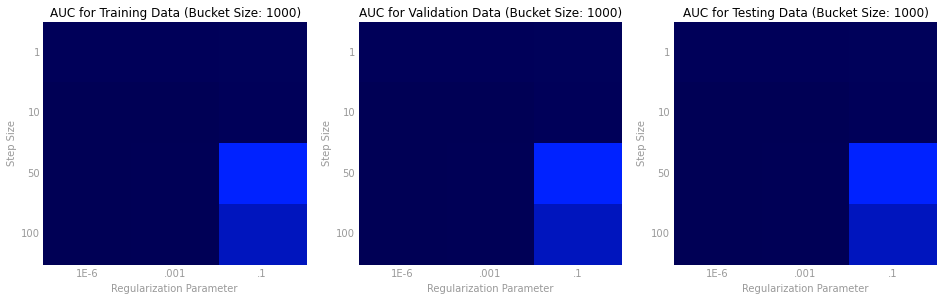

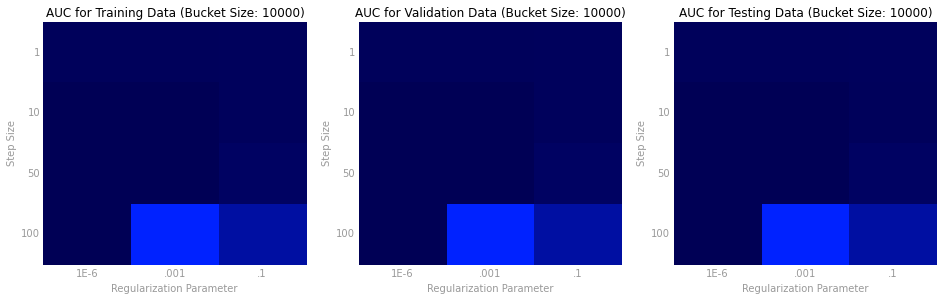

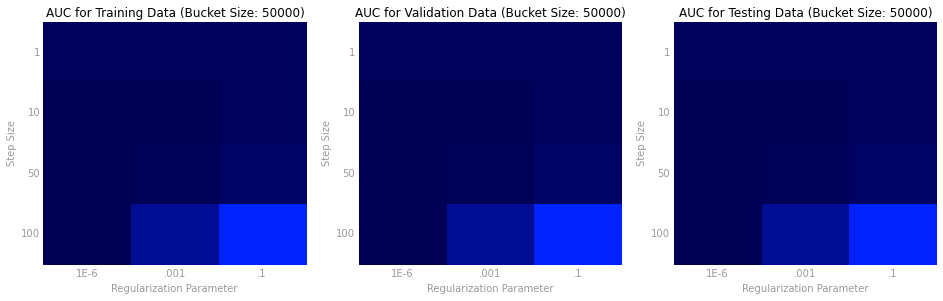

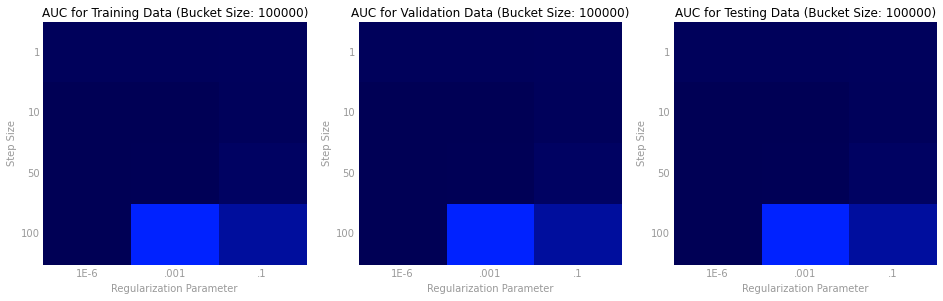

Figures of AUC for Training Data with 1000 buckets:


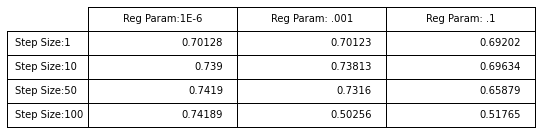

Figures of AUC for Validation Data with 1000 buckets:


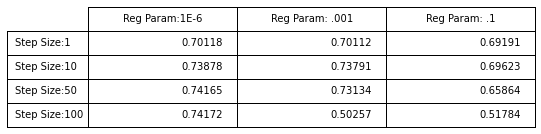

Figures of AUC for Testing Data with 1000 buckets:


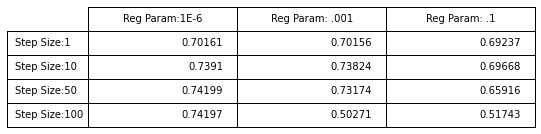

Figures of AUC for Training Data with 10000 buckets:


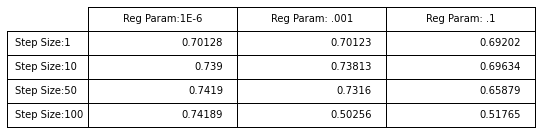

Figures of AUC for Validation Data with 10000 buckets:


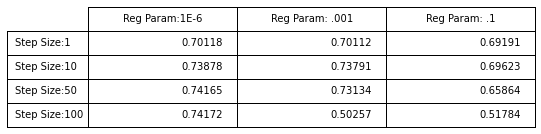

Figures of AUC for Testing Data with 10000 buckets:


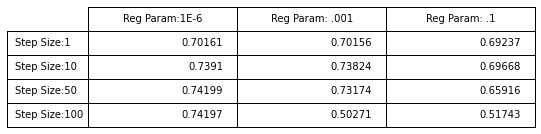

Figures of AUC for Training Data with 50000 buckets:


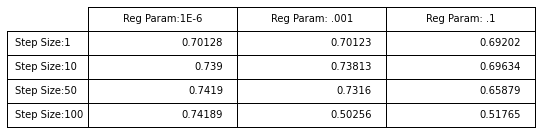

Figures of AUC for Validation Data with 50000 buckets:


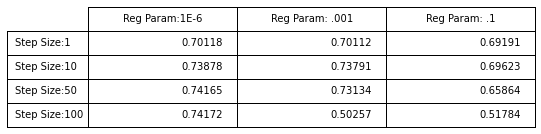

Figures of AUC for Testing Data with 50000 buckets:


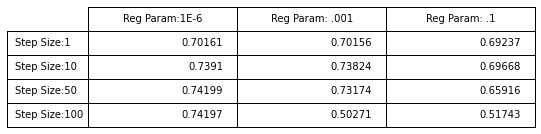

Figures of AUC for Training Data with 100000 buckets:


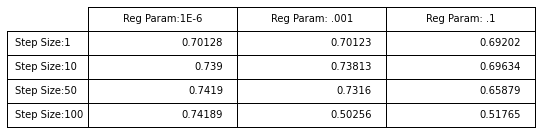

Figures of AUC for Validation Data with 100000 buckets:


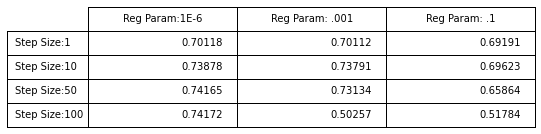

Figures of AUC for Testing Data with 100000 buckets:


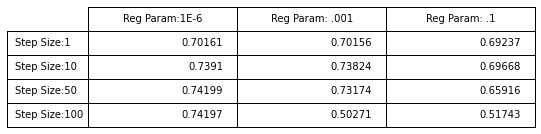

In [123]:
createTable([1000,10000, 50000, 100000],"auc")

##13.5.6 Generate Heatmaps and Table of Figures for "Log Loss"

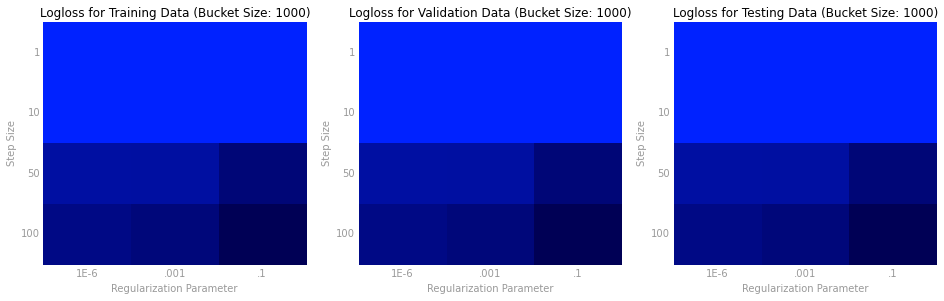

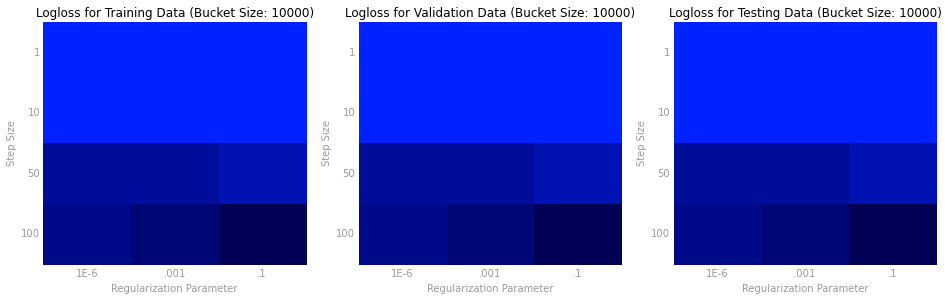

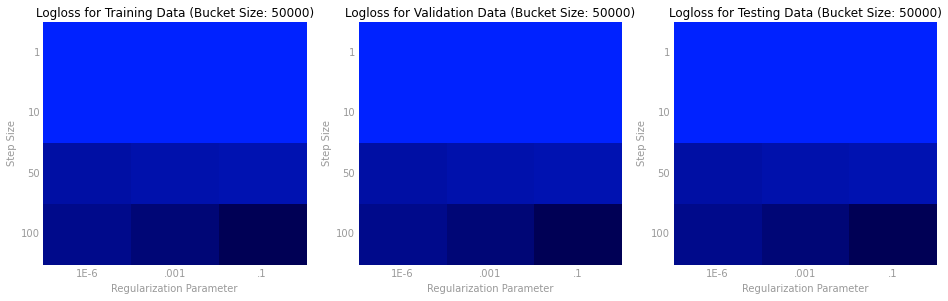

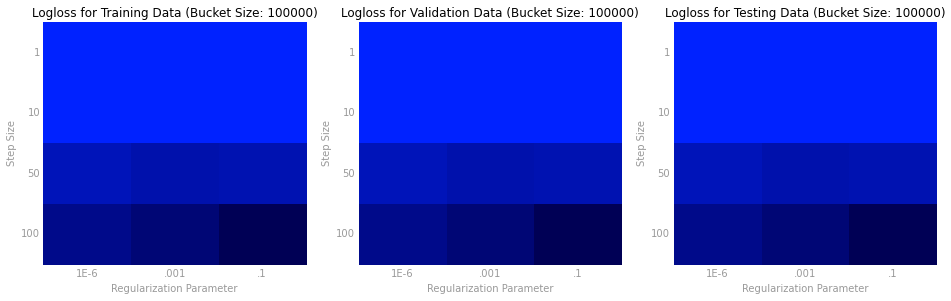

Figures of Logloss for Training Data with 1000 buckets:


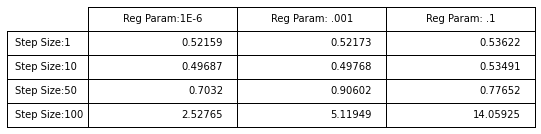

Figures of Logloss for Validation Data with 1000 buckets:


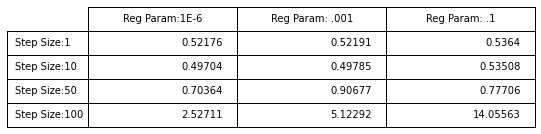

Figures of Logloss for Testing Data with 1000 buckets:


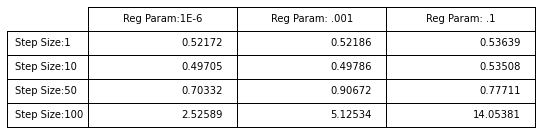

Figures of Logloss for Training Data with 10000 buckets:


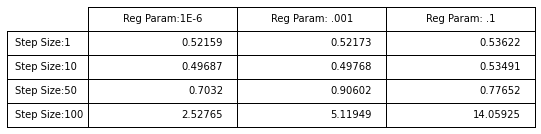

Figures of Logloss for Validation Data with 10000 buckets:


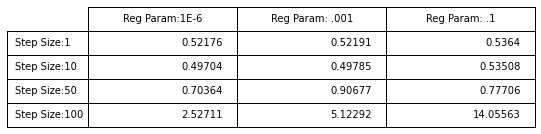

Figures of Logloss for Testing Data with 10000 buckets:


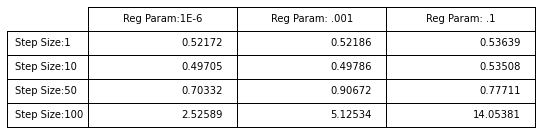

Figures of Logloss for Training Data with 50000 buckets:


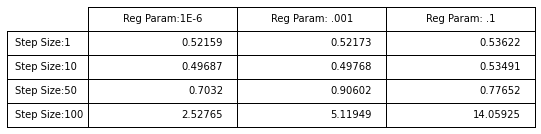

Figures of Logloss for Validation Data with 50000 buckets:


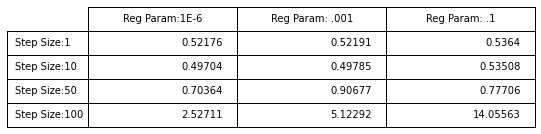

Figures of Logloss for Testing Data with 50000 buckets:


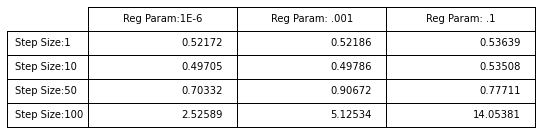

Figures of Logloss for Training Data with 100000 buckets:


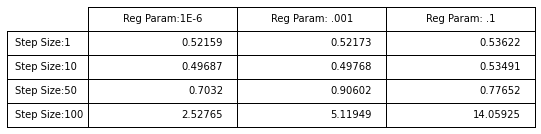

Figures of Logloss for Validation Data with 100000 buckets:


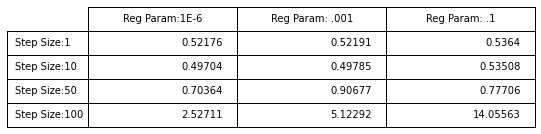

Figures of Logloss for Testing Data with 100000 buckets:


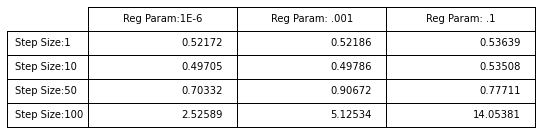

In [119]:
createTable([1000,10000, 50000, 100000],"logloss")

#HW14.2:  AB Test - Testing Significance

>Assume the following scenario: given a control advertising campaign and a treatment advertising campaign, where the control (A) and treatment (B)received 2,000 impressions each. The control and treatment campaigns receive 1 and 6 clicks each respectively. Is the treatment campaign better (statistically significant)? Describe and show you calculations and make a recommendation.

##14.2.1 Setting Up the Question to Answer

We are asked to consider the case where two advertising campaigns, each with 2000 observations, which generated 1 and 6 responses respectively. Are these numbers of responses different? Could these results have been drawn from a single distribution?

Discrete events like this follow the Poisson distribution, and we can examine the question in two ways:

1. What is the probability that 1 response would be seen if the mean number of responses for this population is 6?

2. What is the probability that 6 responses would be seen if the mean number of responses for this population is 1?



##14.2.2 Answering First Question
To examine the first question, we examine the cumulative distribution function for the Poisson distribution to calculate the propbability that the number of observed responses would be 1 (or less):

In [125]:
from scipy.stats import poisson
p_a = poisson.cdf(1.0, 6.0)
print "The probability of seeing 1 response for a mean of 6 is {0:.3f}%".format(100.0*p_a)

The probability of seeing 1 response for a mean of 6 is 1.735%


Since this value is less than 5%, we can reject the null hypothesis.

##14.2.3 Answering Second Quesiton
To examine the second question, we calculate the probability that we might observe 6 or more responses if the true mean is actually 1. Sonce we're looking only at the right tail, we subtract the value of the CDF from 1.

In [126]:
p_a = 1.0 - poisson.cdf(6, 1)
print "The probability of seeing 6 responses for a mean of 1 is {0:.3f}%".format(100.0*p_a)

The probability of seeing 6 responses for a mean of 1 is 0.008%


Since this value is much less than 5% we can again be quite confident in rejecting the null hypothesis here.

##14.2.4 Whether Test Has Sufficient Power

We must also examine whether this population size is sufficient -- whether the test has enough power. We can use Lehr's equation (http://www.columbia.edu/~cjd11/charles_dimaggio/DIRE/styled-4/code-12/#poisson-distributed-or-count-data) with the observation that the square root of Poisson-distributed data is close to normally distributed. We then wish to calculate $ n_{min} = {\frac{4}{(\sqrt{\lambda_1} - \sqrt{\lambda_2})^2}} $ where $\lambda_1$ and $\lambda_2$ are the event rates for the two cases (number of events divided by number of observations).

In [127]:
import numpy as np
nmin = np.ceil(4.0/pow((np.sqrt(1.0/2000.0) - np.sqrt(6.0/2000.0)), 2.0))
print "At least {0:.0f} samples must be taken in each group for power of 0.8".format(nmin/2)

At least 1904 samples must be taken in each group for power of 0.8


Given that we have more samples than the minimum to reach a power of 0.8, we can reject the null hypothesis that the two sets of observations are drawn from a single population, and therefore proceed with the assumption that the observed responses are different, and the treatment evokes more responses than the control.

##14.2.5 Graphical Examination
We can also examine this question graphically. Lets plot the two distributions, assuming means of 1 and 6, for observations of up to 20 events out of 2000 per group.

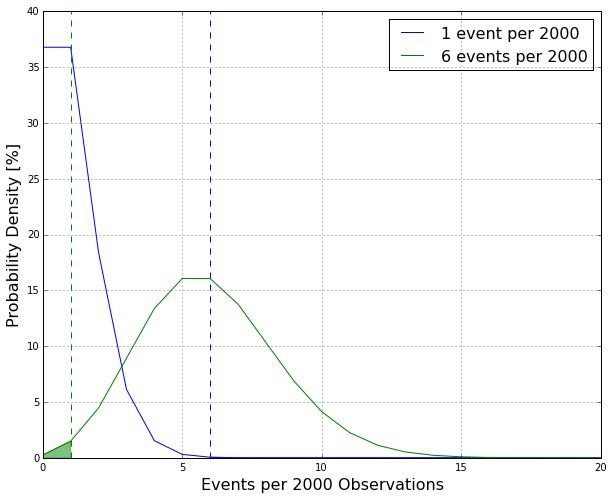

In [128]:
p1=[]
c1 = []
p2=[]
c2 = []
for k in np.arange(21):
    p1.append(poisson.pmf(k, 1.0)*100.0)
    c1.append(poisson.cdf(k, 1.0))
    p2.append(poisson.pmf(k, 6.0)*100.0)
    c2.append(poisson.cdf(k, 6.0))
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(np.arange(21), p1, label='1 event per 2000')
plt.plot(np.arange(21), p2, label='6 events per 2000')
plt.grid()
plt.legend(loc = 'best', fontsize=16)
plt.xlabel('Events per 2000 Observations', size=16)
plt.ylabel('Probability Density [%]', size=16)
plt.axvline(1, color='green', linestyle='dashed')
plt.axvline(6, color='blue', linestyle='dashed')
fig = plt.gcf()
fig.set_size_inches([10,8])
plt.ylim([0, 40])
plt.fill_between([0,1],p2[:2], color='green', alpha=0.5)
plt.fill_between(np.arange(6,21),p1[6:], color='blue', alpha=0.5)

The answer to the first question, the chance of observing 1 event when the true mean is 6, is shown by the green dashed line, roughly 1.7%, and the shaded green area. The answer to the second question, the chance of observing 6 events for a true mean of 1, is shown by the blue dashed line, much less than 1%. The shaded area in this case is too small to see, but we can blow it up as shown below.

(0, 2)

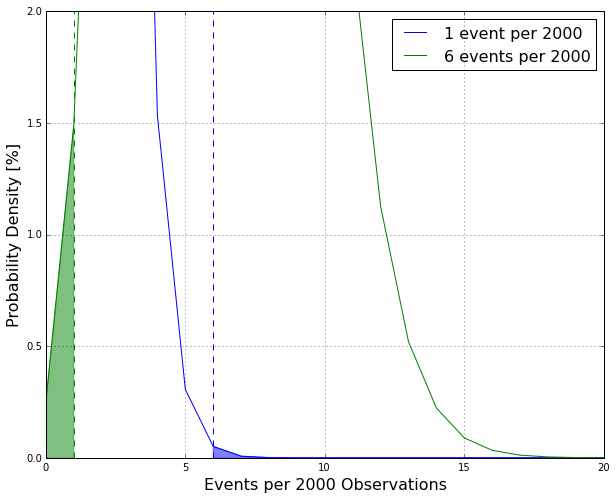

In [129]:
plt.plot(np.arange(21), p1, label='1 event per 2000')
plt.plot(np.arange(21), p2, label='6 events per 2000')
plt.grid()
plt.legend(loc = 'best', fontsize=16)
plt.xlabel('Events per 2000 Observations', size=16)
plt.ylabel('Probability Density [%]', size=16)
plt.axvline(1, color='green', linestyle='dashed')
plt.axvline(6, color='blue', linestyle='dashed')
fig = plt.gcf()
fig.set_size_inches([10,8])
plt.ylim([0, 40])
plt.fill_between([0,1],p2[:2], color='green', alpha=0.5)
plt.fill_between(np.arange(6,21),p1[6:], color='blue', alpha=0.5)
plt.ylim([0, 2])

(0, 1.05)

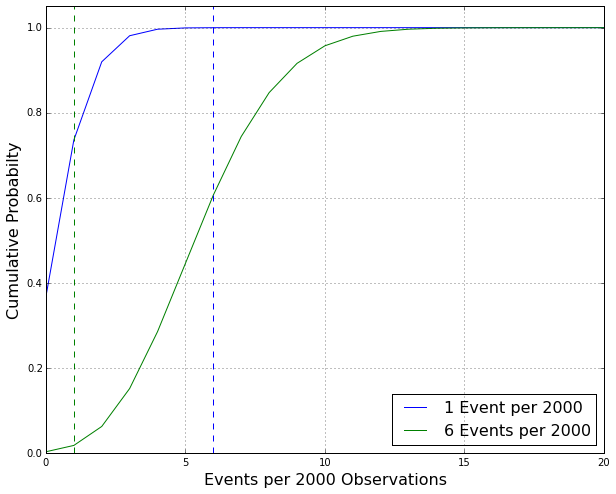

In [130]:
plt.plot(np.arange(21), c1, label='1 Event per 2000')
plt.plot(np.arange(21), c2, label='6 Events per 2000')
plt.grid()
plt.legend(loc = 'best', fontsize=16)
plt.xlabel('Events per 2000 Observations', size=16)
plt.ylabel('Cumulative Probabilty', size=16)
plt.axvline(1, color='green', linestyle='dashed')
plt.axvline(6, color='blue', linestyle='dashed')
fig = plt.gcf()
fig.set_size_inches([10,8])
plt.ylim([0, 1.05])


These areas may be read directly from the cumulative distribution functions, as shown in the figure above. If the true mean is 6 and the measured mean is 1, we examine the CDF value from the 6 Events curve at 1 event, roughly 1.7%. Conversely if the true mean is 1 and we measure 6, we subtract the value of the blue curve at 6 from 1, obtaining something much less than 1%.

#HW 14.3.0 Field-aware Factorization Machine  FFM test on detecting malicious Web sites

>Download the Spark libFM from https://github.com/zhengruifeng/spark-libFM

>Run the FFM code on the hdfs://ns1/whale-tmp/url_combined dataset 

>FFM sample code: https://github.com/zhengruifeng/spark-libFM/blob/master/src/main/scala/TestFM.scala

>on the following dataset:

>url_combined dataset is located at:

>http://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/binary/url_combined.bz2

>Report the AWS cluster configuration that you used and how long in minutes and seconds it takes to complete this job. Discuss the differences in the two factorizations. 

>For some more background on the r detecting malicious Web sites dataset see the following:

>The long-term goal of this research (and this dataset) is to construct a real-time system that uses machine learning techniques to detect malicious URLs (spam, phishing, exploits, and so on). To this end, we have explored techniques that involve classifying URLs based on their lexical and host-based features, as well as online learning to process large numbers of examples and adapt quickly to evolving URLs over time.

>The data set consists of about 2.4 million URLs (examples) and 3.2 million features.
A label of +1 corresponds to a malicious URL and -1 corresponds to a benign URL.
An anonymized 120-day subset of our ICML-09 data set.
Data is encoded in SVM-ligth form
Attack Label, URLs-features, HostID/Address features

>E.g, there are 835,764 unique Hostname-based features T
To implement these features, they  use a bag-of-words representation
of tokens in the URL, where ‘/’, ‘?’, ‘.’, ‘=’, ‘-’,
and ‘ ’ are delimiters. We distinguish tokens that appear in
the hostname, path, the top-level domain (TLD), primary
domain name (the domain name given to a registrar), and
last token of the path (to capture file extensions). Thus,
‘com’ in the TLD position of a URL would be a different
token from ‘com’ in other parts of the URL. We also use
the lengths of the hostname and the URL as features. 


>http://sysnet.ucsd.edu/projects/url/
[JM09a]
Justin Ma, Lawrence K. Saul, Stefan Savage, and Geoffrey M. Voelker. 
Identifying suspicious URLs: An application of large-scale online learning. 
In Proceedings of the Twenty Sixth International Conference on Machine Learning (ICML), pages 681-688, 2009.

>Source: [JM09a] https://www.csie.ntu.edu.tw/~cjlin/libsvmtools/datasets/ref.html#JM09a
Preprocessing: The file "url_original.tar.bz2" contains a directory 121 days, in which the file "FeatureTypes" gives indices of real-valued features (other features are 0/1). The file "url_combined.bz2" combines all 121-day data into one file. See more details in this page.
>number of classes: 2
>number of data: 2,396,130
>number of features: 3,231,961
>Files:
url_combined.bz2
url_original.tar.bz2

>https://www.dropbox.com/s/yz8kcvzyyn4s7bb/url_combined.txt?dl=0

##14.3.0.1 Overview of FFM Setup and Result Summary

**Download the Spark libFM from https://github.com/zhengruifeng/spark-libFM <br><br>
Run the following Field-aware Factorization Machine test: <br><br>
https://github.com/zhengruifeng/spark-libFM/blob/master/src/main/scala/TestFM.scala <br><br>
Describe the dataset. Describe the two experiments: fm1 and fm2 and discuss your results.**

**Dataset:**<br>
The dataset comprises approximately 2.4M lines of the format: <br>
*label feature0:value0 feature1:value1 ... featureN:valueN*

The lines are in sparse format, the labels take values -1 or 1, and the feature values are either binary or take a fractional value between 0 and 1. The total uncompressed data size is about 2.2G.

**Differences in the two factorizations:**
* fm1 trains an FFM using stochastic gradient descent for 100 iterations. This is an iterative method that processes one data point at a time and adjusts the model based on the gradient of the loss function. fm1 uses all of the data in each iteration (it can be configured to use lesS).
* fm2 trains an FFM using limited-memory Broyden–Fletcher–Goldfarb–Shanno for 20 iterations. This algorithm approximates Newton's method (using the gradient and an approximate Hessian) to find a more direct path to convergence than gradient descent.

Both experiments use equivalent parameters otherwise, including for interactions (use global bias term, use one-way interactions, use 4 factors for pairwise interactions) and regularization (all regularization parameters set to 0). There is no output from FFMTest, but we can compare runtimes: with 10 m3.xlarge instances, fm1 required approximately 2 minutes and fm2 13 minutes (15 minutes total).

The original scala code provides no output, so I wrote a function and created an additional RDD calculate log loss. Both fm1 and fm2 had identical log loss of 0.8520897668623415.

##14.3.0.2 Running Spark Job of FFM with Scala on EMR

Below are the commands and code used to set up the cluster and compile and run the code.

In [ ]:
# set up a cluster of 10 m3.xlarge instances
./spark/ec2/spark-ec2 --key-pair=jamesr261 --identity-file=jamesr261.pem -s 12 -t m3.xlarge \
    --region=us-west-1 --zone=us-west-1a launch jr

###Scala file for running the factorization

In [ ]:
import com.github.fommil.netlib.BLAS._
import com.github.fommil.netlib.BLAS.{getInstance => blas}

import scala.util.Random

import org.apache.spark.mllib.linalg._
import org.apache.spark.mllib.evaluation.RegressionMetrics
import org.apache.spark.{SparkConf, SparkContext}
import org.apache.spark.mllib.regression._
import org.apache.spark.mllib.util.MLUtils

object TestFM extends App {

  override def main(args: Array[String]): Unit = {

    val sc = new SparkContext(new SparkConf().setAppName("TESTFM"))

    val training = MLUtils.loadLibSVMFile(sc, "s3n://<access_key>:<secret_key>@ucb-mids-mls-jamesroute-hw5/url_combined", false, -1, 20).cache()

    //    val task = args(1).toInt
    //    val numIterations = args(2).toInt
    //    val stepSize = args(3).toDouble
    //    val miniBatchFraction = args(4).toDouble

    val dataSize = training.count()

    // run with SGD, report log loss
    val fm1 = FMWithSGD.train(training, task = 1, numIterations = 100, stepSize = 0.15, miniBatchFraction = 1.0, dim = (true, true, 4), regParam = (0, 0, 0), initStd = 0.1)
    val logLoss_fm1 = training.map { point =>
      fm1.predict(point.features)
    }.sum() / dataSize
    println("training log loss for fm1 = " + logLoss_fm1)

    // run with LBFGS, report log loss 
    val fm2 = FMWithLBFGS.train(training, task = 1, numIterations = 20, numCorrections = 5, dim = (true, true, 4), regParam = (0, 0, 0), initStd = 0.1)
    val logLoss_fm2 = training.map { point =>
      fm2.predict(point.features)
    }.sum() / dataSize
    println("training log loss for fm2 = " + logLoss_fm2)

  }
}

###SBT file used to build the jar

In [ ]:
name := "TESTFM"

version := "1.0"

scalaVersion := "2.10.4"

libraryDependencies ++= Seq(
  "org.apache.spark" % "spark-core_2.10" % "1.5.1",
  "org.apache.spark" % "spark-mllib_2.10" % "1.5.1"
)

###Command to submit Spark Job

In [ ]:
# driver mem set to 6G to avoid java heap memory issues
~/spark/bin/spark-submit --driver-memory 6G \
    --master spark://ec2-52-53-250-84.us-west-1.compute.amazonaws.com:7077 \
    target/scala-2.10/testfm_2.10-1.0.jar 

#HW 14.3.1  (OPTIONAL) Field-aware Factorization Machine  FFM comparison 
>Using the following training data (where each record is row consisting of a user, item, rating):

>https://www.dropbox.com/s/04rvxpawxelo6b0/test.data.txt?dl=0
 
>Run the following Field-aware Factorization Machine test (note the data may need to be reformatted and one-hot-encoded for this code to work):

>https://github.com/zhengruifeng/spark-libFM/blob/master/src/main/scala/TestFM.scala

>with k (number of factors in the parameter matrix) set to 4.

>What does this model predict for the following test set:

>user=3, item 7, rating=4
user=1, item 2, rating=4
user=6, item 3, rating=4
user=7, item 4, rating=4

>Report the predictions for each example and the mean squared error (MSE).

>Using the ALS algorithm (MLlib), with rank = 4, repeat the above experiment using the following code snippet: 

>https://www.dropbox.com/s/vr3n41ngsnc8kqx/ALS-MLlib.ipynb?dl=0

>Report the predictions on the test set and the MSE. Discuss your results.

#HW 14.4 Replicate Criteo Challenge winning solution

>Using the following as reference material (slides and code):

>3 Idiots’ Approach for Display Advertising Challenge, YuChin Juan, Yong Zhuang, and Wei-Sheng Chin, NTU CSIE MLGroup
https://github.com/guestwalk/kaggle-2014-criteo 
http://www.csie.ntu.edu.tw/~r01922136/kaggle-2014-criteo.pdf

>and the Criteo data: The data for this challenge is located at:

>Raw Data:  (Training, Validation and Test data)
https://console.aws.amazon.com/s3/home?region=us-west-1#&bucket=criteo-dataset&prefix=rawdata/

>Hashed Data: Training, Validation and Test data in hash encoded (10,000 buckets) and sparse representation
https://console.aws.amazon.com/s3/home?region=us-west-1#&bucket=criteo-dataset&prefix=processeddata/

>Replicate (as close as possible) the winning submission for the Criteo. I.e., adapt their 2 step-approach of 
GBDT + Field-aware Factorization Machine (FFM). 

>Report the AWS cluster configuration that you used and how long in minutes and seconds it takes to complete this job.

>Report in tabular form and using heatmaps the AUC values (https://en.wikipedia.org/wiki/Receiver_operating_characteristic) for the Training, Validation, and Testing datasets.
Report in tabular form and using heatmaps  the logLossTest for the Training, Validation, and Testing datasets.

>Don't forget to put a caption on your tables (above the table) and on your heatmap figures (put caption below figures) detailing the experiment associated with each table or figure (data, algorithm used, parameters and settings explored.

>Discuss the optimal setting to solve this problem  in terms of the following:
-- Features
-- Learning algortihm
-- Spark cluster

>Justiy your recommendations based on your experimental results and cross reference with table numbers and figure numbers. Also highlight key results with annotations, both textual and line and box based, on your tables and graphs.

##HW14.4.1 Build GBDT algorithm
Our current implementation of the GBDT algorithm requires us to split into three parts. The first part is to generate the rules of the decision tree. The second part is to tranform category features that appear than 10 times. The third part is to place each data point into a sparse vector of 1 million dimensions with 69 non-zero entries. 

###Create algorithm for generating the rules of decision tree (1st Spark Job)

In [3]:
%%writefile GBDT_Model.py
#!/usr/bin/env python
import sys
from pyspark import SparkContext
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.linalg import SparseVector
from pyspark.mllib.tree import GradientBoostedTrees, GradientBoostedTreesModel
from pyspark.mllib.util import MLUtils
from types import *

def parsePoint(point):
    ##exclude the first 13 features always as they are numerical
    return [(i,j)for i,j in enumerate(point.split(',')[14:])]

def createOneHotDict(inputData):
    sampleDistinctFeats = (inputData #.flatMap(filterNumbers)
                         .flatMap(lambda x: x)
                      .distinct())
    return (sampleDistinctFeats
                           .zipWithIndex()
                             .collectAsMap())  

# TODO: Replace <FILL IN> with appropriate code
def oneHotEncoding(rawFeats, OHEDict, numOHEFeats,first13):
    rawFeats=sorted(rawFeats)
    num=[]
    arr=[]
    for j,i in enumerate(first13):
        if i != '':
            num.append(j)
            arr.append(i)
    OHEFeats=[]
    for i in OHEDict.keys():
        if i in rawFeats:
            OHEFeats.append(i)
                  
    return SparseVector(26+13,sorted(num+\
                            [OHEDict[i]+13 for i in OHEFeats]),\
                        arr+[1.0 for i in range(len(OHEFeats))]) #[i for i in first13]+

def parseOHEPoint(point, OHEDict, numOHEFeats):
    featurelist=point.strip().split(',')
    return LabeledPoint(featurelist[0],oneHotEncoding([(i,j) for i,j in enumerate(featurelist[14:]) ],\
                                                      OHEDict, 26+13,[i for i in featurelist[1:14]]))

def maaro(z):
    if z[1]=='':
        return (-1,0)
    else:
        return(z,1)

#main GBDT function
def run_GBDT(input_file,output_file,iterations):
    dataRDD=sc.textFile(input_file).map(lambda x: x.replace('\t',','))
    #Now let us create labeled point from data
    dataRDDParsed=dataRDD.map(parsePoint).cache()
    featSet=dataRDDParsed.flatMap(lambda x: x).map(maaro).reduceByKey(lambda a,b: a+b).takeOrdered(26,lambda (k,v): -v)
    #reduceByKey(lambda x,y:x+y).takeOrdered(25,lambda (k,v):-v)
    #print featSet
    #OHEdict=createOneHotDict(dataRDDParsed,featSet)
    OHEdict={}
    for i,x in enumerate(featSet):
#         print i,x
        OHEdict[x[0]]=i
   
    #print oneHotEncoding(dataRDDParsed,OHEdict,numSampleOHEFeats,)
    #Now let us create a dictionary of points
#     weights=[.8,.1,.1]
#     seed=42
#     trainRDD,validateRDD,testRDD=dataRDD.randomSplit(weights,seed)
#     OHETrainData = trainRDD.map(lambda point: parseOHEPoint(point, OHEdict, 39))
    OHETrainData = dataRDD.map(lambda point: parseOHEPoint(point, OHEdict, 39))
#     print OHETrainData.take(1)
#     print OHETrainData.count()

    model = (GradientBoostedTrees.trainClassifier(OHETrainData, loss = 'logLoss', numIterations=2, 
             categoricalFeaturesInfo={}, learningRate = 0.1, maxDepth = 7, maxBins = 2))
    
    sc.parallelize([model.toDebugString()]).coalesce(1).saveAsTextFile(output_file)  
    
#Execute code    
if __name__== '__main__':
#     if len(sys.argv) < 3:
#         print >> sys.stderr, "Usage: page_rank <initialize sc ?> <input file> <output file> <damping factor> <number_of_iterations>"
#         exit(-1)

    input_file = sys.argv[1]
    output_file = sys.argv[2]
    input_iterations =int(sys.argv[3])
    
    sc = SparkContext(appName="GBDT")
    run_GBDT(input_file,output_file,input_iterations)
    sc.stop()


Overwriting GBDT_Model.py


###Create algorithm for converting decision tree rules output into Python code (must run locally)

In [ ]:
%%writefile Convert_Python_Rules.py
#!/usr/bin/env python
import sys

def rules_python(input_file, output_file):
    
    spacing = '    '
    
    with open(input_file,'r') as f_in:
        with open(output_file,'w+') as f_out:
            all_lines = []

            for line in f_in:
                text = line.split()
                if text == []:
                    pass
                else:
                    all_lines.append(text)

            starting_indent = 1
            if_indents = {0: starting_indent}
            if_num = 0

            for i in range(len(all_lines)):
                if all_lines[i][0] == 'Tree':
                    indents = starting_indent - 1
                    bin_num = 0
                    tabs = spacing*starting_indent
                    tree_num = int(all_lines[i][1].strip(':'))
                    f_out.write(tabs + '# Tree ' + str(tree_num)+'\n')

                elif all_lines[i][0] == 'If':
                    indents = indents + 1
                    if_indents[if_num] = indents
                    tabs = spacing*indents
                    f_out.write(tabs + 'if ' + all_lines[i][1] + '[' + all_lines[i][2] + ']' + all_lines[i][3] + all_lines[i][4] + ':'+'\n')
                    if_num += 1

                elif all_lines[i][0] == 'Else':
                    indents = if_indents[if_num - 1]
                    tabs = spacing*indents
                    f_out.write(tabs + 'else:'+'\n')
                    if_num -= 1

                elif all_lines[i][0] == 'Predict:':
                    indents = indents + 1
                    tabs = spacing*indents
                    f_out.write(tabs + 'bin_num[' + str(tree_num) + '] = ' + str(bin_num)+'\n')
                    bin_num += 1
                    indents = indents - 1

if __name__== '__main__':
    rules_python(sys.argv[1],sys.argv[2])
    

###Create algorithm for transforming categorical features (C1-C26) appearing less than 10 times into a sepcial value (2nd Spark Job)

In [14]:
%%writefile CriteoFirstPreprocessOHE.py
import sys
import ast
import json
from pyspark import SparkContext
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.linalg import SparseVector


#Compile a tuple of categorical feature and its value
def parsePointForCategoricalOnly(point):
    """Converts a comma separated string into a list of (featureID, value) tuples ONLY IF value is not an integer. 
    Note:
        featureIDs should start at 0 and increase to the number of features - 1.

    Args:
        point (str): A comma separated string where the first value is the label and the rest
            are features.

    Returns:
        list: A list of (featureID, value) tuples.
        [(1, "cat"), (1,"dog"), ... ]
    """
    values = [x for x in point.split("\t")]
    num_features = len(values)
    x = []
    
    #get only 14th feature and after
    index = 0
    for i in range(14, num_features):
            x.append((index, values[i]))
            index +=1
    return x

#create one-hot-encoder dictionary given a raw input
def createOneHotDict(categoricalDataOnly):
    """Creates a one-hot-encoder dictionary based on the input data.

    Args:
        inputData  NOW RDD of tuple of all of the features -- OLD  (RDD of lists of (int, str)): An RDD of observations where each observation is
            made up of a list of (featureID, value) tuples.

    Returns:
        dict: A dictionary where the keys are (featureID, value) tuples and map to values that are
            unique integers.
            [((3, "cat"),4),((1, "dog"),1)] 
    """
    #get tuples for each 
    #inputData = rawData.map(parsePointForCategoricalOnly)
    #print parsedTrainFeat.take(1)
    
    #remove collectAsMap as creating dictionay would not work well with large datasets!
    return (categoricalDataOnly
            .flatMap(lambda x: x) #everything here and below is to create a dictionary
            .distinct()
            .sortByKey()
            .zipWithIndex()      
           )
    #return (rawData
    #        .map(parsePointForCategoricalOnly) #get tuple of all of the features
    #        .flatMap(lambda x: x) #everything here and below is to create a dictionary
    #        .distinct()
    #        .sortByKey()
    #        .zipWithIndex()
    #        .collectAsMap()            
    #       )

def oneHotEncoding(rawFeats, OHEDict, numOHEFeats):
    """Produce a one-hot-encoding from a list of features and an OHE dictionary.

    Note:
        If a (featureID, value) tuple doesn't have a corresponding key in OHEDict it should be
        ignored.

    Args:
        rawFeats (list of (int, str)): The features corresponding to a single observation.  Each
            feature consists of a tuple of featureID and the feature's value. (e.g. sampleOne)
        OHEDict (now RDD for performance reason -- OLD (dict):   A mapping of (featureID, value) to unique integer.
        numOHEFeats (int): The total number of unique OHE features (combinations of featureID and
            value).

    Returns:
        SparseVector: A SparseVector of length numOHEFeats with indicies equal to the unique
            identifiers for the (featureID, value) combinations that occur in the observation and
            with values equal to 1.0.
    """
    #print >> sys.stderr, OHEDict    
    #format of OHEDict
    #((14, u'4a0593ee'), 0)
    
    featureArray = []
    for featTuple in rawFeats:
        
        if featTuple in OHEDict: #tuple is in the dict 
            featureArray.append(OHEDict[featTuple])
        else: #skip it
            pass
    
    #sort the indices
    featureArray.sort()
    
    #we are assuming no duplicates, thus occurrence of each feature is 1 (last parameter in SparseVector)
    return SparseVector(numOHEFeats, featureArray,[1] * len(featureArray))

#for each line of data return either sparse vector or raw data, given a dictionary
def parseOHEPoint(point, OHEDict, getRaw=False):
    """Obtain the label and feature vector for this raw observation.

    Note:
        You must use the function `oneHotEncoding` in this implementation or later portions
        of this lab may not function as expected.

    Args:
        point (str): A comma separated string where the first value is the label and the rest
            are features.
        OHEDict  it's now an RDD for performance reason --OLD -  (dict of (int, str) to int): Mapping of (featureID, value) to unique integer.
        getRaw: if false, return LabelPoint with SparseVector for categorical features. 
                if true, return "\t" delimited mixture of integer and categorical features 
                        withon categorical features having value of either 0 or 1 

    Returns:
        LabeledPoint: Contains the label for the observation and the one-hot-encoding of the
            raw features based on the provided OHE dictionary.
    """
    #numOHEFeats = len(OHEDict)
    numOHEFeats = OHEDict.count()
    #print >> sys.stderr, OHEDict

    values = [x for x in point.split("\t")]
    num_features = len(values)
    x = []
    
    #per Criteo Winner's Powerpoint we will treat only 14th feature and later as categorical
    for i in range(14, num_features):
        x.append((i, values[i]))
    features = oneHotEncoding(x, OHEDict, numOHEFeats)
    
    if getRaw: #must collect label and integer features in addition to the categorical ones
        rawDataArray = []
        
        #get label and integer features
        for i in range(0,13):
            rawDataArray.append(values[i])
        
        #now convert SparseVector features to 
        rawDataArray.extend([str(int(x)) for x in features.toArray().tolist()])
        return "\t".join(rawDataArray)
        
    else: 
        return LabeledPoint(values[0], features)


def main_preprocessWithOHE(input_file, limit, output_file):
    
    #test on sample
    rawData = sc.textFile(input_file) #'dac_sample.txt'
    #rawData.cache() #cache since it will be used later to generate final preprocessed output
    
    categoricalDataOnly = rawData.map(parsePointForCategoricalOnly).flatMap(lambda x: x) # \get tuple of only categorical features
    categoricalDataOnly.cache()
    
    #create dictionary of all of the features
    #prelimOHEDict = categoricalDataOnly \
    #        .distinct() #\
            #.sortByKey() #\
            #.zipWithIndex()     
           
    #prelimOHEDict = createOneHotDict(rawData) 
    #print prelimOHEDict.take(1)
    #(14, u'4a0593ee')
   
    #apply OHE to each data based on dictionary created above
    #prelimOHETrainData = categoricalDataOnly.map(lambda point: parseOHEPoint(point, prelimOHEDict))
    
    #now get count of each features so we can prune them
    #featCounts = (prelimOHETrainData
    #          .flatMap(lambda lp: lp.features.indices)
    #          .map(lambda x: (x, 1))
    #          .reduceByKey(lambda x, y: x + y)).sortByKey()
    featCounts = (categoricalDataOnly
                .map(lambda x: (x,1))
                .reduceByKey(lambda x, y: x + y)).sortByKey()
    #print featCounts.take(30) 
    #format
    #[((14, u'1695330e'), 2), ((14, u'169f6798'), 5), ((14, u'16a99cfb'), 12)]
    
    #based on the count prune and create new dictionary
    prunedOHCDictionary = featCounts \
        .filter(lambda keyValue: keyValue[1] >= int(limit)) \
        .map(lambda x: "C" + str(x[0][0]) + "_" + str(x[0][1])) 
        
#    print prunedOHCDictionary.take(10)
#    return
    
              #.join(featCounts) #\
              #.filter(lambda keyValue: keyValue[1][1] >= int(limit)) \
              #.sortByKey() \
              #.map(lambda x: str(x[1][0][0]) + "_" + str(x[1][0][1]))  #.zipWithIndex().collectAsMap() #take(10)
    #prunedOHCDictionary = prelimOHEDict \
    #          .map(lambda x: (x[0],x[1])) \
    #          .join(featCounts) \
    #          .filter(lambda keyValue: keyValue[1][1] >= int(limit)) \
    #          .sortByKey() \
    #          .map(lambda x: str(x[1][0][0]) + "_" + str(x[1][0][1]))  #.zipWithIndex().collectAsMap() #take(10)
    #key, value =  prunedOHCDictionary.popitem()
    #print key
    #print value
    #print prunedOHCDictionary.take(1)
    prunedOHCDictionary.saveAsTextFile(output_file)

    #parse raw data again and create features
    #finalTrainData = rawData.map(lambda point: parseOHEPoint(point, prunedOHCDictionary, True))
    #OHETrainDataPruned.cache()
    #print OHETrainDataPruned.take(1)    
    
    #finalTrainData.saveAsTextFile(output_file)
    
if __name__ == "__main__":
    
    # two arguments
    #  1. input file
    #  2. limit
    #  3. output file
    
    if len(sys.argv) < 3:
        print >> sys.stderr, "Usage: input_file limit_for_frequency_of_features <output_file>"
        exit(-1)

    [input_file, limit, output_file] = sys.argv[1:4]
    
    sc = SparkContext(appName="PreprocessOHE")
    main_preprocessWithOHE(input_file, limit, output_file)    
    sc.stop()

Overwriting CriteoFirstPreprocessOHE.py


###Create algorithm for placing data into bins according to decision tree rules with hashing (3rd Spark Job)

In [34]:
%%writefile GBDT2_Bins.py
#!/usr/bin/env python
import sys
from pyspark import SparkContext
from pyspark.mllib.regression import LabeledPoint
from pyspark.mllib.linalg import SparseVector
from pyspark.mllib.util import MLUtils
from types import *
import hashlib
import math

#hash like 3 idiots!
def hashLike3Idiots(strToHash,numHashBuckets):
    return int(int(hashlib.md5(strToHash.encode('utf8')).hexdigest(), 16)%numHashBuckets)

def get_hashed_bins(point, numHashBuckets,frequentCategories):
    #input is a tuple
    #1st item is row label,2nd is sparse vector, 3rd item is a tuple (category index array, category value array)
    #[(u'0', 
    #(SparseVector(39, {0: 1.0, 1: 1.0, 2: 5.0, 3: 0.0, 4: 1382.0, 5: 4.0, 6: 15.0, 7: 2.0, 8: 181.0, 9: 1.0, 10: 2.0, 12: 2.0, 13: 1.0, 14: 1.0, 17: 1.0, 19: 1.0, 22: 1.0, 25: 1.0, 28: 1.0, 29: 1.0, 31: 1.0, 32: 1.0}), 
    #([39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 61, 62, 63, 64], [u'68fd1e64', u'80e26c9b', u'fb936136', u'7b4723c4', u'25c83c98', u'7e0ccccf', u'de7995b8', u'1f89b562', u'a73ee510', u'a8cd5504', u'b2cb9c98', u'37c9c164', u'2824a5f6', u'1adce6ef', u'8ba8b39a', u'891b62e7', u'e5ba7672', u'f54016b9', u'21ddcdc9', u'b1252a9d', u'07b5194c', u'3a171ecb', u'c5c50484', u'e8b83407', u'9727dd16'])))]
    
    feature = SparseVector.toArray(point[1][0])
    
    bin_num = {}
    
#NEW_RULES_HERE
    
    final_features = []
    for i in range(30):
        string = str(i+1) + ":" + str(int(bin_num[i]))
        hashed_bin = int(int(hashlib.md5(string.encode('utf8')).hexdigest(), 16)%numHashBuckets)
        final_features.append(hashed_bin)
    
    #now handle integer, #first 13 items in feature vector is an integer
    for i in range(14):
        #create text like "I1-3"
        key = "I" + str(i)
        featureValue = feature[i]
        #if len(featureValue) == 0: #empty value will be treated as zero
        #    featureValue = 0
        
        if int(featureValue) > 2:
            featureValue = int(math.log(float(featureValue))**2)
        else: 
            featureValue = 'SP'+str(featureValue)
        final_features.append(hashLike3Idiots(key+"-" + str(featureValue),numHashBuckets))
        #final_features.append(key+"-" + str(featureValue))

    #now handle cateogry
    for index, featureValue in enumerate(point[1][1][1]):
        key = "C" + str(index)

        #create text like "C16_913ff151"
        keyValueString = key + "_" + featureValue

# During preprocessing step B, three idiots implemented an additional special handling of categorical variables. They took all of the categories within a feature which occurred less than 10 times and put them into the same bucket, by labeling them as C{index}Less. We initially tried to implement this but we ran into a performance issue and ran out of time to refactor the code. Hence, we had to drop that part of the preprocessing B.
#         #print keyValueString
#         if not keyValueString in frequentCategories: #did this cat happen more than 10 times? 
#             keyValueString = key + 'less' #per 3 idiots' source code

        #final_features.append(keyValueString)
        final_features.append(hashLike3Idiots(keyValueString,numHashBuckets))

    label = point[0]

    #print final_features
    
#    new_point = LabeledPoint(point.label, final_features)
    return getFinalLabeledPoint(label, final_features,numHashBuckets)

def parsePoint(point):
    ##exclude the first 13 features always as they are numerical
    return ([(i,j)for i,j in enumerate(point.split(',')[14:])])

def createOneHotDict(inputData):
    sampleDistinctFeats = (inputData #.flatMap(filterNumbers)
                         .flatMap(lambda x: x)
                      .distinct())
    return (sampleDistinctFeats
                           .zipWithIndex()
                             .collectAsMap())  

# TODO: Replace <FILL IN> with appropriate code
def oneHotEncoding(rawFeats, OHEDict, numOHEFeats,first13, last26):
    
    rawFeats=sorted(rawFeats)
    num13=[]
    arr13=[]
    for j,i in enumerate(first13):
        if i != '':
            num13.append(j)
            arr13.append(i)
    num26=[]
    arr26=[]
    for j,i in enumerate(last26):
        if i != '':
            num26.append(j + 39)
            arr26.append(i)
    OHEFeats=[]
    for i in rawFeats:
        if i in OHEDict.keys():
            OHEFeats.append(i)

    return (SparseVector(13+26, \
                        sorted(num13+[OHEDict[i]+13 for i in OHEFeats]),\
                        arr13+[1.0 for i in range(len(OHEFeats))]),
                        (num26,arr26))
            
#    return SparseVector(13+26+26,sorted(num13+\
#                            [OHEDict[i]+13 for i in OHEFeats]+num26),\
#                        arr13+[1.0 for i in range(len(OHEFeats))]+arr26)


def parseOHEPoint(point, OHEDict, numOHEFeats):
    #input
    #(u'0,1,1,5,0,1382,9727dd16, so on... ')
    featurelist=point.strip().split(',')

    new_point = (featurelist[0],oneHotEncoding([(i,j) for i,j in enumerate(featurelist[14:]) ],\
                                                      OHEDict, 13+26+26,[i for i in featurelist[1:14]], \
                                                                        [i for i in featurelist[14:]]))

    return new_point

def maaro(z):
    if z[1]=='':
        return (-1,0)
    else:
        return(z,1)

"""
def parseNonGBDTFeatures(point, frequentCategories,numHashBuckets):
    #format
    #(u'0,1,1,5,0,1382,9727dd16, so on... ', 0) 

    indexCount = 0
    catCount = 0
    features = point[0].split(',')

    modFeatures = []
    
    #print features
    
    for index, featureValue in enumerate(features):
        if index != 0: #ignore first one (label)
            if index <14: #integer
                #create text like "I1-3"
                key = "I" + str(index)
                #print featureValue
                #print index
                if len(featureValue) == 0: #empty value will be treated as zero
                    featureValue = 0
                    
                if int(featureValue) > 2:
                    featureValue = int(math.log(float(featureValue))**2)
                else: 
                    featureValue = 'SP'+str(featureValue)
                modFeatures.append(hashLike3Idiots(key+"-" + str(featureValue),numHashBuckets))
                indexCount +=1
            else:

                key = "C" + str(catCount)
                
                #create text like "C16_913ff151"
                keyValueString = key + "_" + featureValue
                
                #print keyValueString
                
                if not keyValueString in frequentCategories: #did this cat happen more than 10 times? 
                    keyValueString = key + 'less' #per 3 idiots' source code
                    
                modFeatures.append(hashLike3Idiots(keyValueString,numHashBuckets))
                
                catCount +=1
    
    #print indexCount
    #print catCount
    #output format (rowindex, label, features)
    
    #print modFeatures
    label = int(features[0])
    rowIndex = point[1]
    return (rowIndex,(label,modFeatures))
"""

#get Labeled Point based on my arr
def getFinalLabeledPoint(label, myarr,numBuckets):
    
    #remove duplicates
    myarr = sorted(list(set(myarr)))

    keyArray = []
    countArray = []

    for item in myarr:
        keyArray.append(item)
        countArray.append(1)
    #print numBuckets
    #print keyArray
    #print countArray
    #return SparseVector(numBuckets,keyArray,countArray)
    return LabeledPoint(label,SparseVector(numBuckets,keyArray,countArray))

def processFinalJoin(point,numBuckets):
    
    #(x[1][0][0],x[1][0][1] + x[1][1][1]))
    label = point[1][0][0]
    features = point[1][0][1] + point[1][1][1]  
    return getFinalLabeledPoint(label, features,numBuckets)

def run_bins(input_file,output_file, numHashBuckets, frequentCategories_file):
    #repeat of before to generate OHETrainDataBins
    dataRDD=sc.textFile(input_file).map(lambda x: x.replace('\t',','))  #.zipWithIndex()
    #format
    #last integer is an index of the record, we will use it to join result of GBDT with additional Preprocessing B result
    #(u'0,1,1,5,0,1382,9727dd16, so on... ', 0) 
    dataRDD.cache()

#############################    
##### Begin Preprocessing B for integer and categories
#     frequentCategoriesRDD = sc.textFile(frequentCategories_file).collect() #format-- array of text like C14_23425
    
#     freqCategories = sc.broadcast(frequentCategoriesRDD)
#     modifiedIntAndCat = dataRDD.map(lambda x: parseNonGBDTFeatures(x,freqCategories.value, numHashBuckets))
#     #print modifiedIntAndCat.take(1)
#     #format (HASHED of below)
#     #[(rowIndex, (label, ['I1-SP1', 'I2-SP1', 'I3-2', 'I4-SP0', 'I5-52', 'I6-1', 'I7-7', 'I8-SP2', 'I9-27', 'I10-SP1', 'I11-SP2', 'I12-SP0', 'I13-SP2', u'C0_68fd1e64', u'C1_80e26c9b', 'C2less', 'C3less', u'C4_25c83c98', u'C5_7e0ccccf', u'C6_de7995b8', u'C7_1f89b562', u'C8_a73ee510', u'C9_a8cd5504', u'C10_b2cb9c98', 'C11less', u'C12_2824a5f6', u'C13_1adce6ef', u'C14_8ba8b39a', 'C15less', u'C16_e5ba7672', u'C17_f54016b9', u'C18_21ddcdc9', u'C19_b1252a9d', 'C20less', u'C21_', u'C22_3a171ecb', u'C23_c5c50484', u'C24_e8b83407', 'C25less']))]  
##### END Preprocessing B for integer and categories
#############################    

    frequentCategoriesRDD = sc.textFile(frequentCategories_file).collect() #format-- array of text like C14_23425
    
    #freqCategories = sc.broadcast(frequentCategoriesRDD)
    
############################    
##### Begin GBDT processing

    dataRDDParsed=dataRDD.map(parsePoint).cache()
    #format
    #([....(24, u'e8b83407'), (25, u'9727dd16')], 0)
    
    #print dataRDDParsed.take(1)
    featSet=dataRDDParsed.flatMap(lambda x: x).map(maaro) \
        .reduceByKey(lambda a,b: a+b).takeOrdered(26,lambda (k,v): -v)
        
    OHEdict={}
    for i,x in enumerate(featSet):
        OHEdict[x[0]]=i

    OHETrainData = dataRDD.map(lambda point: parseOHEPoint(point, OHEdict, 13+26+26))
    
    #print OHETrainData.take(1)
    #return 
    #OHETrainData should now be in the format:
    #(SparseVector(65, [0, ..., 64], [I0, I1, ..., I12, OHE0, OHE1, ..., OHE25, C0, C1, ..., C25]))
    #print "OHETrain"
    #print OHETrainData.take(1)
        
    #apply the new decision tree
#     OHETrainDataDense = OHETrainData.map(lambda x: SparseVector.toArray(x.features))
#     OHETrainDataBins = OHETrainDataDense.map(lambda x: get_bins(x))
#     OHETrainDataBins.coalesce(1).saveAsTextFile(output_file)


    OHETrainDataBins = OHETrainData.map(lambda point: get_hashed_bins(point, numHashBuckets,frequentCategoriesRDD))


#   OHETrainDataBins.saveAsTextFile(output_file)   
    #OHETrainDataBins format:
    #(rowindex, (label, [hashed GBDT assignment 232, 384, 576, 952, 528, 960, 984, 600, 552, 640, 576, 296, 144, 344, 744, 480, 832, 96, 536, 256, 304, 264, 160, 632, 960, 312, 440, 400, 264, 304]))]
##### End GBDT processing    
############################    
    
    
############Now merge set of two features
    #joined = OHETrainDataBins.join(modifiedIntAndCat)
    #after join
    #[(0, ((u'0', [232, 384, 576, 952, 528, 960, 984, 600, 552, 640, 576, 296, 144, 344, 744, 480, 832, 96, 536, 256, 304, 264, 160, 632, 960, 312, 440, 400, 264, 304]),
     #     (0, [480, 720, 688, 856, 392, 24, 184, 480, 432, 696, 16, 368, 352, 368, 368, 160, 608, 392, 680, 768, 936, 432, 424, 112, 840, 264, 536, 152, 80, 440, 360, 640, 600, 520, 304, 128, 592, 952, 536])))]

    #joinedProcessed = joined.map(lambda x: (x[1][0][0],x[1][0][1] + x[1][1][1]))
    #joinedProcessed.cache()
    #print joinedProcessed.take(1)

    #print joinedProcessed.map(lambda x: getFinalLabeledPoint(x[0], x[1], numHashBuckets)).take(1)

    #return 
#     FinalLabeledPoint =  OHETrainDataBins.join(modifiedIntAndCat).map(lambda x: processFinalJoin(x,numHashBuckets))

    #freqCategories.unpersist()
    MLUtils.saveAsLibSVMFile(OHETrainDataBins, output_file) 
    

if __name__== '__main__':
    
    if len(sys.argv) < 4:
        print >> sys.stderr, "Usage: <input file> <output file> <number of hash buckets>  <frequentCategories>"
        exit(-1)

    input_file = sys.argv[1]
    output_file = sys.argv[2]
    numHashBuckets = float(sys.argv[3])
    freqCats = sys.argv[4]
    
    sc = SparkContext(appName="GBDT2")
    run_bins(input_file,output_file, numHashBuckets,freqCats)
    sc.stop()


Overwriting GBDT2_Bins.py


##14.4.2 Run GBDT algorithm to Preprocess for FFM

In [8]:
#Create Spark job
!aws emr create-cluster --name "14_4" --release-label emr-4.2.0 --applications Name=Spark \
    --instance-count 10 --use-default-roles --ec2-attributes KeyName=w261_key2 --instance-type m3.xlarge \
    --enable-debugging --log-uri s3://hw14/14_2 \
    --configurations file://./emr_config_spark_max.json 

j-1AGASUV9PRSQY


In [10]:
#Look up the IP from EMR console & ssh into the cluster by giving local permission
#>>> ssh -i <key_name> hadoop@ec2-52-35-157-35.us-west-2.compute.amazonaws.com

#At the local termainal, copy main PySpark files into EMR master node
PEM_HOME="/Users/maktrix/Dropbox/Berkeley/W261_ML_scale"
!scp -i $PEM_HOME/w261_key2.pem GBDT_Model.py hadoop@ec2-52-35-157-35.us-west-2.compute.amazonaws.com:.
!scp -i $PEM_HOME/w261_key2.pem CriteoFirstPreprocessOHE.py hadoop@ec2-52-35-157-35.us-west-2.compute.amazonaws.com:.

#Remove output folder of same name
out_dir="14_4_gbdt_model"
!aws s3 rm --recursive s3://hw14/$out_dir

GBDT_Model.py                                 100% 3482     3.4KB/s   00:00    
GBDT2_Bins.py                                 100%   43KB  42.8KB/s   00:00    
CriteoFirstPreprocessOHE.py                   100% 8911     8.7KB/s   00:00    


#### Run 1st Spark job on EMR to generate decision tree rules:
- time /usr/lib/spark/bin/spark-submit --master yarn-cluster ./GBDT_Model.py s3n://criteo-dataset/rawdata/train/ s3n://hw14/14_4_gbdt_model 30

#### Run 2nd Spark job on to transform categorical features with less than 10:
- time /usr/lib/spark/bin/spark-submit --master yarn-cluster ./CriteoFirstPreprocessOHE.py s3n://criteo-dataset/rawdata/train/ s3n://hw14/14_4_gbdt_model 10 s3n://hw14/14_4_atleast10

In [35]:
#KEY STEP: insert the decision tree rules into the Python file
#ALWAYS DO THIS STEP LOCALLY (DON'T TRY TO DO THIS IN THE CLOUD)
#The final GBDT2_Bins.py will then be uploaded to the EMR master node
out_dir="14_4_gbdt_model"
!rm -r $out_dir
!aws s3 cp --recursive s3://hw14/$out_dir $out_dir
!python ./Convert_Python_Rules.py $out_dir/part-00000 gbdt_python_rules.txt
!sed -i '' '/#NEW_RULES_HERE/r gbdt_python_rules.txt' GBDT2_Bins.py
!scp -i $PEM_HOME/w261_key2.pem GBDT2_Bins.py hadoop@ec2-52-35-157-35.us-west-2.compute.amazonaws.com:.


download: s3://hw14/14_4_gbdt_model/_SUCCESS to 14_4_gbdt_model/_SUCCESS
download: s3://hw14/14_4_gbdt_model/part-00000 to 14_4_gbdt_model/part-00000
GBDT2_Bins.py                                 100%  483KB 483.1KB/s   00:00    


In [33]:
out_dir = '14_4_BeforeFFM_train'
!aws s3 rm --recursive s3://hw14/$out_dir

#### Run 3rd Spark job on training, validation and testing dataset to preprocess the data for FFM:
- time /usr/lib/spark/bin/spark-submit ./GBDT2_Bins.py s3n://criteo-dataset/rawdata/train/ s3n://ucb-mids-mls-kasaneutsumi/14_4_BeforeFFM_train 1e6 s3n://hw14/14_4_atleast10
- time /usr/lib/spark/bin/spark-submit ./GBDT2_Bins.py s3n://criteo-dataset/rawdata/train/ s3n://ucb-mids-mls-kasaneutsumi/14_4_BeforeFFM_validation 1e6 s3n://hw14/14_4_atleast10
- time /usr/lib/spark/bin/spark-submit ./GBDT2_Bins.py s3n://criteo-dataset/rawdata/train/ s3n://ucb-mids-mls-kasaneutsumi/14_4_BeforeFFM_test 1e6 s3n://hw14/14_4_atleast10

##14.4.3 Run FFM Algorithm
This is the scala file for running FFM on the training dataset and calculating log loss and AUC on the training set. It is compiled and run the same way as the code in 14.3.

In [ ]:
import com.github.fommil.netlib.BLAS._
import com.github.fommil.netlib.BLAS.{getInstance => blas}

import scala.util.Random

import org.apache.spark.rdd.RDD
import org.apache.spark.mllib.linalg._
import org.apache.spark.mllib.evaluation.RegressionMetrics
import org.apache.spark.{SparkConf, SparkContext}
import org.apache.spark.mllib.regression._
import org.apache.spark.mllib.util.MLUtils
import org.apache.spark.mllib.evaluation.BinaryClassificationMetrics


object TestFM extends App {

  /**
    * print log loss and AUC for a model and dataset
    * model: trained FMM model
    * data: RDD containing training/validation/test data
    * desc: string used as title of dataset
    */
  def getMetrics(model: FMModel,
                 data: RDD[LabeledPoint],
                 desc: String): Unit = {

    val dataSize = data.count()
    val preds = data.map { point =>
      val prediction = model.predict(point.features)
      (prediction, point.label)
    }

    val logLoss = preds.map { pred_label =>
      computeLogLoss(pred_label._1, pred_label._2)
      }.sum() / dataSize

    val metrics = new BinaryClassificationMetrics(preds)
    val auROC = metrics.areaUnderROC

    println(desc + " log loss = " + logLoss)
    println("Area under ROC = " + auROC)
  }

  /**
    * function to compute log loss
    * p: model probability for given data point
    * y: label for data point
    */
  def computeLogLoss(p: Double, y: Double): Double = {
    val epsilon = 10E-12
    var x = math.max(epsilon, p)
    x = math.min(1 - epsilon, p)
    val logLoss = y*math.log(x) + (1-y)*math.log(1-x)
    return -logLoss
  }

  override def main(args: Array[String]): Unit = {

    val sc = new SparkContext(new SparkConf().setAppName("TESTFM"))

    // process args. args 0-3 specify data locations. rest are hyperparams
    val train_in = args(0)
    val val_in = args(1)
    val test_in = args(2)
    val step_size = args(3).toDouble
    val reg = args(4).toDouble
    val num_iter = args(5).toInt

    // read in data
    val training = MLUtils.loadLibSVMFile(sc, train_in).cache()
    val validate = MLUtils.loadLibSVMFile(sc, val_in).cache()
    val test = MLUtils.loadLibSVMFile(sc, test_in).cache()

    // train model
    val fm1 = FMWithSGD.train(training, task = 1, numIterations = num_iter, stepSize = step_size, miniBatchFraction = 1.0, dim = (true, true, 4), regParam = (reg, reg, reg), initStd = 0.1)

    // get metrics against training, validation, and test sets
    getMetrics(fm1, training, "training")
    getMetrics(fm1, validate, "validation")
    getMetrics(fm1, test, "test")
  }
}

Sample command to run FFM on the cluster, from the project's root directory. The arguments are as follows:
1. training set location
2. validation set location
3. test set location
4. step size
5. regulation param
6. number of iterations

####Run below command inside the master node after setting up the jar file:

In [ ]:
/usr/lib/spark/bin/spark-submit  --driver-memory 6G \
    target/scala-2.10/testfm_2.10-1.0.jar \
    s3n://ucb-mids-mls-kasaneutsumi/14_4_BeforeFFM_train \
    s3n://ucb-mids-mls-kasaneutsumi/14_4_BeforeFFM_validation \
    s3n://ucb-mids-mls-kasaneutsumi/14_4_BeforeFFM_test 1.5 1E-6 100

##14.4.4 Final Results

In [ ]:
test log loss = 0.5759344589269916
Area under ROC = 0.6313824600398236